## Bayesian Methods for Volume Fraction Analysis of Pair Distribution Functions
Written by Carl Strandby, Chalmers University of Technology, for a Project Course on data processing in Material's Science in 2023. Email: carstran@student.chalmers.se or carl.strandby@gmail.com


This Jupyter Notebook is an application of Bayesian Analysis techniques to Pair Distribution Function (PDF) data aimed at determining phase volume fractions of a Multi-Principal Element Alloy (MPEA) with the atomic composition (Hf, Nb, Ta, Ti, Zr). The methodology for calculating volume fractions in PDFs draws from work by Magnus Hörnqvist Colliander's Microstructure Physics group at Chalmers University of Technology. In particular, the application of the diffpy package and associated equations builds on work by Yao Hu, Chalmers University of Technology. The Bayesian Analysis approach used here is informed by the courses 'Advanced Simulations and Machine Learning' and 'Learning From Data' at Chalmers University, the former taught by Paul Erhart, Andreas Ekström, Arkady Gonoskov, and the latter Christian Forsén. The excellent lecture notes by Christian Forsén are publicly available at [Lecture Notes to Learning From Data ](https://cforssen.gitlab.io/tif285-book/content/Intro/welcome.html). Additionally, this Notebook introduces basic High Performance Computing (HPC) techniques to expedite computational tasks. The foundational concepts of HPC were acquired in a course taught by Martin Raum at Chalmers University, details of which can be found at [High Performance Computing by Martin Raum](https://hpc.raum-brothers.eu/). Note that the original course utilized a different programming language and hence concepts have been adapted to Python. The primary focus of this Notebook is to demonstrate coding implementations for Bayesian Analysis for diffraction experiments in materials science.

---
## Notebook Overview
    
**1. Experiment Description**

    An introduction to synchrotron measurements of Pair Distribution Functions, detailing the experimental setup and data acquisition process.

**2. Introduction to Bayesian Analysis**

    A brief overview of Bayesian Analysis concepts, emphasizing their relevance and application in materials science data analysis.

**3. A short introduction to High Performance Computing Techniques**

    Presentation of essential High Performance Computing techniques, focusing on efficiency rules and best practices in Python.

**4. Simulating Pair Distribution Functions for diffraction experiments**

    Guidelines on how to generate Pair Distribution Functions simulating real-world diffraction experiments.

**5. Calculating PDFs for a mixture of phases**

    Exploring methods to calculate Pair Distribution Functions for materials comprising multiple phases.
    
**6. Generation of measurement data**

    Techniques for generating realistic measurement data, simulating conditions observed in synchrotron experiments.

**7. Non-Bayesian methods; the root mean square minima**

    Examination of traditional non-Bayesian approaches, particularly focusing on the root mean square minimization technique.

**8. Bayesian methods to calculate volume fractions**

    Detailed application of Bayesian methods for the quantification of phase volume fractions in materials.

**9. Bayesian Analysis for identifying phase transitions**

    Utilizing Bayesian Analysis to detect and analyze phase transitions within the material's structure.

**10. Future Improvements**

    Reflections on the limitations of current methodologies with suggestions for future advancements and research directions.

---
## Learning Objectives
By the end of this notebook, you should have developed a comprehensive understanding of how Bayesian methods can be applied to analyze diffraction data in materials science. Additionally, you should have gained insights into the application of basic High Performance Computing concepts for writing more efficient Python code.

---
## 1. Experiment Description

This Jupyter Notebook focuses on some aspects of conducting diffraction experiments, particularly the extraction and simulation of Pair Distribution Functions (PDFs). We describe a hypothetical experiment in which a Multi-Principal Element Alloy (MPEA) undergoes an annealing process, altering its phase composition from predominantly Body-Centered-Cubic (BCC) to a mixture including Hexagonal-Close-Packed (HCP), reflected in changes in the measured PDF.

### A) Converting Diffraction Experiment Results to a PDF in Real Space

Synchrotron-based diffraction experiments involve X-ray interactions with materials, yielding diffraction patterns. The transformation of these patterns into Pair Distribution Functions (PDFs) in real space is accomplished through Fourier Transform. The PDFs provides information about atomic distances within the material, revealing insights into material structures and their fundamental properties.

The hypothetical experiment adapted for this notebook involves using a synchrotron setup to monitor changes in PDFs as a Multi-Principal Element Alloy (MPEA) sample of (Hf, Nb, Ta, Ti, Zr) is heated. The phase transitions in the sample manifest as changes in the measured PDF. Specifically, this work focuses on a scenario where the initial phase is Body-Centered-Cubic (BCC) and, upon heating, the volume fraction of the Hexagonal-Close-Packed (HCP) phase increases.

### B) Simulating a PDF

Simulating PDFs allows for predictions of atomic arrangements and proof-of-concept demonstrations for method development. In this notebook, the crystal structures of the examined MPEA are modeled with the diffpy package. This involves specifying atomic compositions, occupation numbers, and isotropic displacement parameters (Uiso), as well as calculating scattering factors. However, due to compatibility issues with newer Python versions, the scattering factors are also provided in a CSV file for convenience.

### C) Calculating a PDF from a Mixture of Phases

Understanding materials often requires analyzing systems composed of multiple phases. The overall PDF, $g$, can be represented as a weighted sum of the individual phase PDFs

\begin{equation}
g = w_1 \cdot g_1 + w_2 \cdot g_2,
\end{equation}

where $w_1$ and $w_2$ are the weight factors for two PDFs for pure BCC and HCP, here denoted $g_1$ and $g_2$. These weight factors depend on the volume fractions and scattering characteristics of each phase calculated as

\begin{equation}
w_1 = \frac{(1 - \phi) \cdot S_{q1}}{(1 - \phi) \cdot S_{q1} + \phi \cdot S_{q2}}
, \qquad 
w_2 = \frac{\phi \cdot S_{q2}}{(1 - \phi) \cdot S_{q1} + \phi \cdot S_{q2}}.
\end{equation}

Here $\phi$ represents the volume fraction of the examined HCP phase, and $S_{q1}$ and $S_{q2}$ are the accumulated scattering sums dependent on the scattering factors and occupancies of the two phases. 

Instead of simulating the actual heating of the MPEA sample, we calculate PDFs for various HCP volume fractions, from 0 to 1. This process simulates a heating response by allowing us to design a hypothetical function for the true volume fraction changing due to heating.

### D) Simulating Noisy Measurement Data
Real-world data often includes noise and errors, which must be replicated in simulations to realistic experimental conditions. For PDF data, this means incorporating random noise that scales with intensity, linear errors, and potential outliers representing sudden environmental changes. Including these aspects in our simulations ensures that the methodologies developed can provide accurate insights, even in the presence of data imperfections.

---
## 2. Introduction to Bayesian Analysis

Bayesian analysis is a statistical tool that puts a particular emphasis on accompanying probabilities with uncertainties or confidence intervals. A particular nuance lies in the ability to incoprorate prior knowledge about a system. In this work, Bayesian analysis allows us to calculate an entire posterior probability distribution of the volume fraction of a PDF, the quantiles of which can be used as the uncertainty ranges. 

The essence of Bayesian analysis lies in the concept of the posterior probability distribution, which represents the likelihood of a model's accuracy given measured data. Here model refers to fitted parameters, in this case the volume fraction and some uncertainty parameters. The posterior is given by multiplying the likelihood probability, the probability of a model producing the measured data, with the prior probability, that is, the prior assumptions about the model. Traditionally, the Bayes formula includes an Evidence denominator, representing the probability of observing the measured data under any model. However, in practice this is often omitted as it is a constant for the model and does not influence the comparisons between different models.

In practical applications, it is common to apply logarithmic transformations to the likelihood and prior probabilities. This transformation often provides increased accuracy as it avoids the handling of very small numbers, common in the tails of a distribution, and simplifies the multiplication of probabilities into a sum of logarithms, enhancing numerical stability. Hence, we typically work with the log-posterior probability

\begin{equation}
    \text{Posterior} = \frac{\text{Likelihood} \times \text{Prior}}{\text{Evidence}}
    \quad \implies \quad 
    \log\left(\text{Posterior}\right) \sim \log\left(\text{Likelihood}\right) + \log\left(\text{Prior}\right)
\end{equation}

The two components of the log-posterior can be calculated separately. The log-likelihood function, quantifying the probability of observing the measured data for a given model, is in this work a normal distribution of the errors of a model's prediction and is computed as follows:

    1. Calculate the error or residual at each data point by subtracting the model's prediction for that data point from the measured value.

    2. Sum the squares of these errors.

    3. Divide this sum by a model uncertainty hyperparameter, which is a prior encoding our uncertainty about the model's precision.

    4. The resulting value, termed the Mean-Squared-Error (MSE), is then used as argument in the exponent of a normal distribution.

    5. Normalize the distribution and take the logarithm of the result.

The log-prior function is central to Bayesian analysis, allowing for the incorpotation of prior knowledge or assumptions of the model. This function can encode various constraints, such as probabilities not taking on negative values. The choice of the prior is subjective and should be made carefully to avoid introducing biases into the analysis. For instance, in linear regression, the selection of a uniform prior can inadvertently bias the result. The principle of maximum entropy can guide the selection of priors, advocating for the choice of the distribution that maximizes entropy (uncertainty) while satisfying known constraints.

---
## 3. A short introduction to High Performance Computing Techniques

In the realm of data processing and simulations, efficiency and speed are important, especially when dealing with large datasets or complex computations. High Performance Computing (HPC) techniques can be used to optimize these tasks. 

One fundamental aspect of optimizing code is the elimination of redundant calculations. Efficiency can be significantly improved by identifying computations that are unnecessarily repeated and restructuring the code to perform these calculations just once. In fact, one such calculation in an initial version of this notebook was the calculation of the accumulated scattering sum for the MPEA for each volume fraction of HCP from 0 to 1, despite this factor being a constant. Just calculating this once provided a significant speed up, reducing the computation time of one MCMC sampling from four minutes to three seconds.

One HPC method is analyzing how code is compiled by the computer. The instructions given to a compiler changes how the compiler writes machine code, executable by the computer, based on the python code in this notebook. One compilation-based improbvement in this notebook is the inclusion of the JIT compilation flag from the package Numba, a just-in-time compiler for Python. The JIT flag specifiec that the function should be optimized for performance. This extra optimization introduces some overhead but in cases where a function, such as the one calculating PDFs, is called many times within a loop the more optimized machine code can offer substantial speed improvements. Note that if the function is called only a few times the extra overhead will decrease performance. 

Vectorization is another powerful technique. It involves performing operations on entire arrays instead of processing each element individually. Python's list comprehensions, combined with NumPy, can use these vectorized operations. This is because list comprehension has a predictable structure, causing compiled machine code to be shorter and more efficient. Especially simpler for-loops of the type:

    for item in list:
        if condition:
            expression

can often be written more efficiently with list comprehension:

    [expression for item in list if condition]


Parallelization is another HPC technique allowing the simultaneous execution of independent processes. The Python package joblib can facilitate this by enabling parallel processing of tasks, such as the MCMC simulations in this work. It should be noted that parallelization of a function is only possible if the function calls are independent from eachother. 

---
## 4. Simulating Pair Distribution Functions for diffraction experiments

In this chapter Pair Distribution Functions (PDFs) are calculated for combinations of BCC and HCP by either calculating the individual phases PDFs and the MPEA scattering factors with diffpy or by reading them from an attached file.

The cell below you to customize the notebook's operations. Key settings include the option to generate and save atomic data or load pre-existing data from a CSV file. This flexibility ensures compatibility with different Python versions, avoiding the need to downgrade Python to 3.7 for compatibility with the diffpy package.

In [1]:
# Notebook settings determining which parts of the notebook to run
#
####################################################################################################

notebook_settings = {
    "generate_atomic_data": False, # Requires diffpy and hence Python 3.7
    "save_generated_atomic_data": False, # Saves the generated atomic data to csv file
    "save_generated_atomic_data_path": "data/Bayesian_Methods_For_Volume_Fraction_Analysis/", # Path to save the generated atomic data to
    "load_generated_atomic_data": True, # Loads the generated atomic data from the above path
    "save_volume_fraction_analysis": False, # Saves the volume fraction analysis to csv file
    }


Import statements are placed at the beginning of the notebook to clearly outline the required packages. 

The set_plot_style function establishes a standard plotting style, optimized for integration with LaTeX documents. In particular, figure sizes incremented by factors of 3.5 often requires less scaling in LaTeX.

In [2]:
# Importing packages
#
####################################################################################################

# Standard imports
import numpy as np
import pandas as pd
from dataclasses import dataclass

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize

# Timing for benchmarking
from timeit import timeit

# Numba for speeding up calculations inside MCMC loop
# jit compiles the function to machine code the first time it is called and then runs the compiled code for subsequent calls
from numba import jit

# Parallelisation
from joblib import Parallel, delayed

# MCMC and statistics
import emcee
from scipy import special


# Diffpy for generating PDFs, requires Python 3.7, only used if notebook_settings["generate_atomic_data"] is True
# Note that the Diffpy package is also not included in the requirements file for binder. 
if notebook_settings["generate_atomic_data"]:
    from diffpy.Structure import Atom, Lattice, Structure
    from diffpy.srreal.pdfcalculator import PDFCalculator
    
####################################################################################################
#
# Setting the standard plot style
#
####################################################################################################

def set_plot_style():
    
    """
    Sets the plot style to a standard style that is suitable for LaTeX documents.
    
    Input:
        None
    
    Output:
        None
    
    """
    
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette("deep")
    sns.set(font='sans-serif')
    
    fig_width=3.5
    fig_height=3.5

    plt.rcParams['figure.figsize'] = (fig_width, fig_height)
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 4
    plt.rcParams['font.size'] = 2 * fig_width
    
    # Set grid lines off
    plt.rcParams['axes.grid'] = True

set_plot_style()


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject



### A) Create PDF for materials with diffpy

In this section, we define key material constants for both the BCC and HCP phases. These constants include lattice parameters, atomic compositions, and isotropic displacement parameters, which are essential for accurately simulating the PDFs of these materials.

In [3]:
# Sets lattice parameters and occupancies for the BCC and HCP structures
a_bcc = 3.402
a_hcp = 3.202
c_hcp = 5.092

atoms = ("Hf", "Nb", "Ta", "Ti", "Zr")
occ_bcc = (0.22, 0.18, 0.19, 0.20, 0.20)
occ_hcp = (0.3721, 0.0075, 0.0762, 0.1043, 0.4399)

# U_iso values at 600K for both structures (guess by Carl with HCP being half of BCC)
Uiso_bcc = 0.035
Uiso_hcp = 0.01525


Phase properties can be stored either in dictionaries or using custom data classes. While dictionaries are straightforward, data classes offer improved performance and readability. Below, we demonstrate the implementation of data classes for storing the properties of BCC and HCP phases

Phase properties can either be saved in a dictionary like this:

In [4]:
bcc_phase_properties = {"a": a_bcc, "atoms": atoms, "occ": occ_bcc, "Uiso": Uiso_bcc}
hcp_phase_properties = {"a": a_hcp, "c": c_hcp, "atoms": atoms, "occ": occ_hcp, "Uiso": Uiso_hcp}

Or we can create data classes for storing the properties of BCC and HCP phases:

In [5]:
# Dataclass for the BCC and HCP structures
#
####################################################################################################

@dataclass
class BCCPhase:
    
    """ 
    Custom class for the BCC structure 
    
    Properties:
        a: lattice parameter
        atoms: tuple of atoms
        occ: tuple of occupancies
        Uiso: isotropic displacement parameter
        
    """
    
    a: float
    atoms: tuple
    occ: tuple
    Uiso: float

@dataclass
class HCPPhase:
    
    """ 
    Custom class for the HCP structure 
    
    Properties:
        a: lattice parameter
        c: lattice parameter
        atoms: tuple of atoms
        occ: tuple of occupancies
        Uiso: isotropic displacement parameter
        
    """
    a: float
    c: float
    atoms: tuple
    occ: tuple
    Uiso: float

The dataclasses can then be iniitialize them like this:

In [6]:
bcc_phase = BCCPhase(a_bcc, atoms, occ_bcc, Uiso_bcc)
hcp_phase = HCPPhase(a_hcp, c_hcp, atoms, occ_hcp, Uiso_hcp)

for phase in (bcc_phase, hcp_phase):
    # Print the dataclass name of the phase
    print(f"{phase.__class__.__name__}:")
    
    # Print the properties of the phase
    for property in phase.__dataclass_fields__:
        print(f"  {property} = {getattr(phase, property)}")
    print("\n")

BCCPhase:
  a = 3.402
  atoms = ('Hf', 'Nb', 'Ta', 'Ti', 'Zr')
  occ = (0.22, 0.18, 0.19, 0.2, 0.2)
  Uiso = 0.035


HCPPhase:
  a = 3.202
  c = 5.092
  atoms = ('Hf', 'Nb', 'Ta', 'Ti', 'Zr')
  occ = (0.3721, 0.0075, 0.0762, 0.1043, 0.4399)
  Uiso = 0.01525




### B) Calculating PDFs for pure phases

Now, we proceed to generate the atomic data for the BCC and HCP structures. Using the diffpy package, we'll create PDFs, denoted as g(r), for both BCC and HCP phases, along with the scattering factors for each element within these materials.

Diffpy requires Python 3.7, which means users might need to downgrade their Python version. However, newer versions of Python offer improved performance and additional features. Therefore there is the option to save generated atomic data to CSV files, enabling users to switch to newer Python versions for subsequent calculations. For users without Python 3.7 we also include the option of loading an attached CSV file.

In [7]:
# Diffpy functions for generating PDFs
#
####################################################################################################


if notebook_settings["generate_atomic_data"]:

    def create_BCC_Structure(lat_par, at_list, occ_list):
        
        """ 
        Creates a Body-Centered Cubic (BCC) crystal structure using the diffpy package.
        
        Input:
            lat_par (float): Lattice parameter of the BCC structure.
            at_list (list): List of atomic species present in the structure.
            occ_list (list): List of occupancies for each atomic species.
        
        Output:
            Structure: A diffpy.Structure.Structure object representing the BCC structure.
        
        """
        
        struct = Structure(lattice = Lattice(lat_par, lat_par, lat_par, 90, 90, 90))
        global index
        for index, at in enumerate(at_list):
            at1 = Atom(at, [0, 0, 0], occupancy = occ_list[index])
            at2 = Atom(at, [0.5, 0.5, 0.5], occupancy = occ_list[index])
            struct.addNewAtom(at1)
            struct.addNewAtom(at2)
            
        return struct

    def create_HCP_Structure(a, c, at_list, occ_list):
        
        """ 
        Creates a Hexagonal Close-Packed (HCP) crystal structure using the diffpy package.

        Input:
            a (float): First lattice parameter of the HCP structure.
            c (float): Second lattice parameter of the HCP structure.
            at_list (list): List of atomic species present in the structure.
            occ_list (list): List of occupancies for each atomic species.
        
        Output:
            Structure: A diffpy.Structure.Structure object representing the HCP structure.
        
        """
        
        struct = Structure(lattice = Lattice(a, a, c, 90, 90, 120))
        global index
        for index, at in enumerate(at_list):
            at1 = Atom(at, [0.33, 0.67, 0.25], occupancy = occ_list[index])
            at2 = Atom(at, [0.67, 0.33, 0.75], occupancy = occ_list[index])
            struct.addNewAtom(at1)
            struct.addNewAtom(at2)
            
        return struct

    def ChangeUiso(self,Uxx):
        
        """ 
        Changes the isotropic displacement parameter (Uiso) of a crystal structure to a specified value using the diffpy package.

        Input:
            Uxx (float): The new Uiso value to be applied to the structure.
        
        Output:
            Structure: A new Structure object with the updated Uiso value.
        
        """
        
        new_stru_U = self.copy()
        new_stru_U.isotropy = True
        new_stru_U.Uisoequiv = Uxx
        return new_stru_U

    def SetUpPDFCalc(PDF_params_dict):
        
        """ 
        Sets up a Pair Distribution Function (PDF) calculator with specified parameters using the diffpy package.

        Input:
            PDF_params_dict (dict): A dictionary containing PDF calculation parameters. Keys include 'qbroad', 'qdamp', 'delta2', 'qmin', 'qmax', 'rmin', 'rmax', and 'rstep'.
        
        Output:
            PDFCalculator: A configured instance of PDFCalculator.
        
        """
        
        pdfc = PDFCalculator()
        pdfc.scatteringfactortable = "N"
        pdfc.qbroad = PDF_params_dict['qbroad']
        pdfc.qdamp = PDF_params_dict['qdamp']
        pdfc.delta2 = PDF_params_dict['delta2']
        pdfc.qmin = PDF_params_dict['qmin']
        pdfc.qmax = PDF_params_dict['qmax']
        pdfc.rmin = PDF_params_dict['rmin']
        pdfc.rmax = PDF_params_dict['rmax']
        pdfc.rstep = PDF_params_dict['rstep']
        return pdfc

In [8]:
# Functions for generating atomic data with diffpy
#
####################################################################################################

def generate_atomic_data():
    
    """
    Generates the atomic data for the BCC and HCP structures and saves them to csv files using the diffpy package.
    
    Input:
        None
    
    Output:
        None
    
    """
    
    # Parameters for the PDF calculator
    PDF_params_dict = { "qbroad": 0.01572, "qdamp": 0.04277, "delta2": 5.138, 
                        "qmin": 0.5, "qmax": 24, "qstep": 0.02, 
                        "rmin": 0, "rmax": 20, "rstep": 0.01
                      }

    # Set up the PDF calculator with the above parameters
    pc = SetUpPDFCalc(PDF_params_dict)
    
    # Create BCC and HCP structures and set their Uiso values
    bcc_temp = (create_BCC_Structure(a_bcc, atoms, occ_bcc))
    hcp_temp = (create_HCP_Structure(a_hcp, c_hcp, atoms, occ_hcp))
    bcc = ChangeUiso(bcc_temp, Uiso_bcc)
    hcp = ChangeUiso(hcp_temp, Uiso_hcp)
    
    # Calculate the PDFs (g(r)) and keeps the r and g(r) values in separate arrays. Second r left out as it is the same as the first r.
    r, g_bcc = pc(bcc)
    _, g_hcp = pc(hcp)
    
    # Create a dataframe for easier access of properties and faster saving to csv
    df_rg = pd.DataFrame({"r": r, "g_bcc": g_bcc, "g_hcp": g_hcp})
    
    df_scattering_factors = pd.DataFrame(columns = ["Element", "Scattering factor"])
    
    for elem in atoms:
        df_scattering_factors = df_scattering_factors.append({"Element": elem, "Scattering factor": pc.scatteringfactortable.lookup(elem)}, ignore_index=True)
    
    if notebook_settings["save_generated_atomic_data"]:
        df_rg.to_csv(notebook_settings["save_generated_atomic_data_path"] + "rg.csv")
        df_scattering_factors.to_csv(notebook_settings["save_generated_atomic_data_path"] + "scattering_factors.csv", index=False)
    
    print("Generated atomic data saved to " + notebook_settings["save_generated_atomic_data_path"])
    
    return df_rg, df_scattering_factors, r, g_bcc, g_hcp


In [9]:
if notebook_settings["generate_atomic_data"]:
    df_rg, df_scattering_factors, r, g_bcc, g_hcp = generate_atomic_data()

### C) Loading PDFs from CSV
We can now load the previously generated atomic data using the following function:

In [10]:
# Functions for loading atomic data
#
####################################################################################################


def load_atomic_data():
    
    """
    Loads the atomic data for the BCC and HCP structures from csv files.
    
    Input:
        None
    
    Output:
        None
    
    """
    
    df_rg = pd.read_csv(notebook_settings["save_generated_atomic_data_path"] + "rg.csv", index_col=0)
    df_scattering_factors = pd.read_csv(notebook_settings["save_generated_atomic_data_path"] + "scattering_factors.csv")
    
    print("Loaded atomic data from " + notebook_settings["save_generated_atomic_data_path"])
    
    return df_rg, df_scattering_factors


In [11]:
if notebook_settings["load_generated_atomic_data"]:
    df_rg, df_scattering_factors = load_atomic_data()
    
    g_bcc = df_rg["g_bcc"].to_numpy()
    g_hcp = df_rg["g_hcp"].to_numpy()
    r = df_rg["r"].to_numpy()

Loaded atomic data from data/Bayesian_Methods_For_Volume_Fraction_Analysis/


### D) Calculating the PDF for mixtures of phases

In this section, we focus on calculating the Pair Distribution Function (PDF) for mixtures of different phases, specifically BCC and HCP structures. We'll explore some efficient methods to compute these PDFs with High Performance Computing techniques. 

The accumulated scattering sums, crucial for PDF calculations, are independent of the volume fractions. Hence, they need only be computed once, providing a significant optimization opportunity. Below, we compare two methods for this calculation; the traditional for-loop and a more efficient method utilizing vectorized operations with our dataclass structures.

In [12]:
# Function to calculate the squared accumulated scattering sum
#
####################################################################################################


def get_squared_accumulated_scattering_sum_for_loop_and_dictionary(phase_properties, df_scattering_factors):
    
    """ 
    Calculates the squared accumulated scattering sum for a given phase using loop and dictionary methods.

    Input:
        phase_properties (dict): A dictionary containing properties of the phase, including 'atoms' and 'occ'.
        df_scattering_factors (DataFrame): A DataFrame containing the scattering factors for elements.

    Output:
        float: The squared accumulated scattering sum for the given phase.
    
    """

        
    result = 1
    for index, elem in enumerate(phase_properties["atoms"]):
        xi = phase_properties["occ"][index]
        bi = df_scattering_factors[df_scattering_factors["Element"] == elem]["Scattering Factor"].values[0]
        result += xi*bi
    return result**2


def get_squared_accumulated_scattering_sum(phase, scattering_factors):
    
    """ 
    Calculates the squared accumulated scattering sum for a given phase using vectorized operations.

    Input:
        phase (object): An object representing the phase, containing 'atoms' and 'occ' as attributes.
        scattering_factors (DataFrame): A DataFrame containing the scattering factors for elements.

    Output:
        float: The squared accumulated scattering sum for the given phase.
    
    """
    
    # We can now get xi as the occupancies of the phase dataclass
    xi = phase.occ
    
    # Scattering factors is a dataframe for which we can lookup the scattering factors for the elements in the phase
    bi = scattering_factors.loc[scattering_factors['Element'].isin(phase.atoms), 'Scattering Factor'].values
    
    result = np.sum(xi * bi) + 1
    
    return result ** 2


In [13]:
# Benchmarking the two functions for calculating the squared accumulated scattering sum
#
####################################################################################################

def perform_benchmark_of_sqass(benchmark_iterations = 10000):
    
    """ 
    Benchmarks two functions for calculating the squared accumulated scattering sum - one using loops and dictionaries and the other using vectorized operations.

    Input:
        benchmark_iterations (int): The number of iterations to benchmark over. Default is 10000.
    
    Output:
        None: This function prints out the timing results and comparison of both methods.
    
    """

    def benchmark_sqass():
        get_squared_accumulated_scattering_sum_for_loop_and_dictionary(bcc_phase_properties, df_scattering_factors)

    def benchmark_sqass_vectorized():
        get_squared_accumulated_scattering_sum(bcc_phase, df_scattering_factors)
    
    benchmark_iterations = 10000
    timers = []
    for benchmark_function in [benchmark_sqass, benchmark_sqass_vectorized]:
        time_per_iteration = timeit(benchmark_function, number=benchmark_iterations)/benchmark_iterations
        timers.append(time_per_iteration)
        print(benchmark_function.__name__ + f': {time_per_iteration:2e} seconds')
        
    print(f"Conclusion: Vectorized version is {timers[0]/timers[1]:.1f} times faster than the non-vectorized version")
    print("\n")

In [14]:
perform_benchmark_of_sqass()

bcc_sq1 = get_squared_accumulated_scattering_sum(bcc_phase, df_scattering_factors)
hcp_sq2 = get_squared_accumulated_scattering_sum(hcp_phase, df_scattering_factors)

print(f"bcc_sq1 = {bcc_sq1}")
print(f"hcp_sq2 = {hcp_sq2}")

benchmark_sqass: 7.999143e-04 seconds
benchmark_sqass_vectorized: 1.453174e-04 seconds
Conclusion: Vectorized version is 5.5 times faster than the non-vectorized version


bcc_sq1 = 36.6027420004
hcp_sq2 = 52.83628208644901


Next we define the function for calculating the PDF for a given volume fraction. 

Another key optimization technique showcased here is the use of the Numba library's 'jit' function. JIT compilation optimizes the Python functions into machine code, significantly speeding up their execution. This is particularly beneficial when a function, like our PDF calculation, is called repeatedly in a loop across various volume fractions. Below compare the performance of the standard Python function and its JIT-compiled counterpart.

In [15]:
# Function to calculate the PDF for a given volume fraction
#
####################################################################################################


def get_g(g1, g2, vol_frac, sq1, sq2):
    
    """
    Calculates the Pair Distribution Function (PDF) for given volume fractions using standard Python functions.

    Input:
        g1, g2 (arrays): Arrays representing the PDFs of two different phases.
        vol_frac (float): Volume fraction of the second phase.
        sq1, sq2 (floats): Squared accumulated scattering sums for the respective phases.

    Output:
        array: The calculated PDF for the given volume fraction.
    
    """

    
    denom = (1 - vol_frac) * sq1 + vol_frac * sq2
    w1 = (1-vol_frac) * sq1 / denom
    w2 = vol_frac * sq2 / denom
    
    return w1*g1 + w2*g2


@jit(nopython=True)
def get_g_jit(g1, g2, vol_frac, sq1, sq2):
    
    """
    Calculates the Pair Distribution Function (PDF) for given volume fractions using Numba's JIT compilation for optimization.

    Input:
        g1, g2 (arrays): Arrays representing the PDFs of two different phases.
        vol_frac (float): Volume fraction of the second phase.
        sq1, sq2 (floats): Squared accumulated scattering sums for the respective phases.

    Output:
        array: The calculated PDF for the given volume fraction.
    
    """
    
    denom = (1 - vol_frac) * sq1 + vol_frac * sq2
    w1 = (1-vol_frac) * sq1 / denom
    w2 = vol_frac * sq2 / denom
    
    return w1*g1 + w2*g2



In [16]:
# Benchmarking the two functions for calculating the PDF
#
####################################################################################################


def perform_benchmark_of_get_g(benchmark_iterations=1e6):
    
    """
    Benchmarks two functions for calculating the PDF - a standard Python function and an optimized JIT version.

    Input:
        benchmark_iterations (int): The number of iterations to benchmark over. Default is 1e6.
    
    Output:
        None: This function prints out the timing results and comparison of both methods.
    
    """

    def benchmark_get_g():
        get_g(g_bcc, g_hcp, 0.5, bcc_sq1, hcp_sq2)

    def benchmark_get_g_jit():
        get_g_jit(g_bcc, g_hcp, 0.5, bcc_sq1, hcp_sq2)
    
    timers = []
    for benchmark_function in [benchmark_get_g, benchmark_get_g_jit]:
        time_per_iteration = timeit(benchmark_function, number=int(benchmark_iterations))/benchmark_iterations
        timers.append(time_per_iteration)
        print(benchmark_function.__name__ + f': {time_per_iteration:2e} seconds')
        
    print(f"Conclusion: JIT version is {timers[0]/timers[1]:.1f} times faster than the standard Python version")
    print("\n")


In [17]:
perform_benchmark_of_get_g()

benchmark_get_g: 5.486883e-06 seconds
benchmark_get_g_jit: 1.477082e-06 seconds
Conclusion: JIT version is 3.7 times faster than the standard Python version




Another strategy for speeding up calculations is through vectorization, often implemented using list comprehension in Python. Compared to traditional for-loops, list comprehension offers a more efficient approach as it minimizes machine code calls, thanks to its predictable structure. NumPy's array operations for all elements simultaneously, as opposed to executing operations element-by-element in standard loops.

The get_G_matrix function computes the G matrix, with each row being the resulting PDF of a particular volume fraction. The first implementation uses a traditional loop-based approach, while get_G_matrix_vectorized employs a vectorized method with list comprehensions.

In [18]:
# Function to calculate the G matrix for various volume fractions
#
####################################################################################################

def get_G_matrix(vol_fracs, g1, g2, sq1, sq2):
    
    """
    Calculates the G matrix for various volume fractions using a loop-based approach.

    Input:
        vol_fracs (list): List of volume fractions.
        g1, g2 (arrays): Arrays representing the Pair Distribution Functions (PDFs) of two different phases.
        sq1, sq2 (floats): Squared accumulated scattering sums for the respective phases.

    Output:
        numpy.ndarray: G matrix calculated for each volume fraction.
        
    """

    G_matrix = np.zeros((len(vol_fracs), len(r)))
    for index, vol_frac in enumerate(vol_fracs):
        G_matrix[index] = get_g(g1, g2, vol_frac, sq1, sq2)
    return G_matrix

def get_G_matrix_vectorized(vol_fracs, g1, g2, sq1, sq2):
    """
    Calculates the G matrix for various volume fractions using a vectorized approach.

    Input:
        vol_fracs (list): List of volume fractions.
        g1, g2 (arrays): Arrays representing the PDFs of two different phases.
        sq1, sq2 (floats): Squared accumulated scattering sums for the respective phases.

    Output:
        numpy.ndarray: G matrix calculated for each volume fraction.
    """

    G_matrix = [get_g_jit(g_bcc, g_hcp, vol_frac, bcc_sq1, hcp_sq2) for vol_frac in vol_fracs]
    return np.array(G_matrix)



In [19]:
# Benchmarking the two functions for calculating the G matrix
#
####################################################################################################


def perform_benchmark_of_get_G_matrix(benchmark_iterations=1e3):
    """
    Benchmarks the calculation of the G matrix using both loop-based and vectorized approaches.

    Input:
        benchmark_iterations (int): Number of iterations for the benchmark. Default is 1e3.

    Output:
        None: This function prints out timing results and comparison of both methods.
    """

    volume_fraction_resolution = 1000
    vol_fracs = np.linspace(0, 1, volume_fraction_resolution)   
    
    def benchmark_G_matrix():
        get_G_matrix(vol_fracs, g_bcc, g_hcp, bcc_sq1, hcp_sq2)
        
    def benchmark_G_matrix_vectorized():
        get_G_matrix_vectorized(vol_fracs, g_bcc, g_hcp, bcc_sq1, hcp_sq2)

    timers = []
    for benchmark_function in [benchmark_G_matrix, benchmark_G_matrix_vectorized]:
        time_per_iteration = timeit(benchmark_function, number=int(benchmark_iterations)) / benchmark_iterations
        timers.append(time_per_iteration)
        
        print(benchmark_function.__name__ + f': {time_per_iteration:2e} seconds')
    
    print(f"Conclusion: Vectorized version is {timers[0]/timers[1]:.1f} times faster than the non-vectorized version")
    print("\n")


perform_benchmark_of_get_G_matrix() 

volume_fraction_resolution = 1000
vol_fracs = np.linspace(0, 1, volume_fraction_resolution)

G_matrix = get_G_matrix_vectorized(vol_fracs, g_bcc, g_hcp, bcc_sq1, hcp_sq2)

benchmark_G_matrix: 7.095520e-03 seconds
benchmark_G_matrix_vectorized: 4.680196e-03 seconds
Conclusion: Vectorized version is 1.5 times faster than the non-vectorized version




Finally, we visualize the 2D PDF map across various volume fractions using a heatmap.

In [20]:
# Function to plot the G matrix
#
####################################################################################################

def plot_heatmap(x, y, z, x_label, y_label, z_label, title):
    """
    Plots a heatmap for the given data.

    Input:
        x, y (arrays): Arrays representing the axes data.
        z (array): Array representing the heatmap data.
        x_label, y_label, z_label (str): Labels for the x-axis, y-axis, and colorbar, respectively.
        title (str): Title of the plot.

    Output:
        None: This function displays the heatmap.
    """

    fig, ax = plt.subplots()
    
    im = ax.imshow(z, cmap='viridis', interpolation='nearest', 
                   origin='lower', aspect='auto', extent=[x[0], x[-1], y[0], y[-1]])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label=z_label)
    # Turn off grid
    ax.grid(False)
    plt.show()

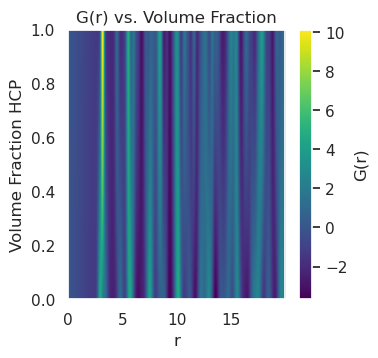

In [21]:
plot_heatmap(r, vol_fracs, G_matrix, "r", "Volume Fraction HCP", "G(r)", "G(r) vs. Volume Fraction")

---
## 6. Generation of measurement data

Before conducting Bayesian analysis, we create a hypothetical measurement for a specific volume fraction. We first calculate a true signal which we add noise to in order to ensure robustness of the Bayesian method.


### A) Create "true" data

We start by generating a 'true' signal, which we'll treat as if it were measured in a laboratory setting with discrete points.

In [22]:
# Function to plot the G matrix for a specific volume fraction
#
####################################################################################################

def plot_Gr(r, g_true, r_data, g_data, title):
    """
    Plots the Pair Distribution Function (PDF) G(r) against the radius r for specific volume fractions.

    Input:
        r (array): Radius array.
        g_true (array): True G(r) values.
        r_data (array): Radius values of the data.
        g_data (array): G(r) values of the data.
        title (str): Title of the plot.

    Output:
        None: This function displays the plot.
    """

    plt.scatter(r_data, g_data, label="Data", color="b")
    plt.plot(r, g_true, label="True", color="r")
    plt.xlabel("r")
    plt.ylabel("G(r)")
    plt.title(title)
    plt.legend()
    plt.show()

The plot_Gr function visualizes the Pair Distribution Function (PDF) G(r) against the radius r for specific volume fractions with the true measurement points.

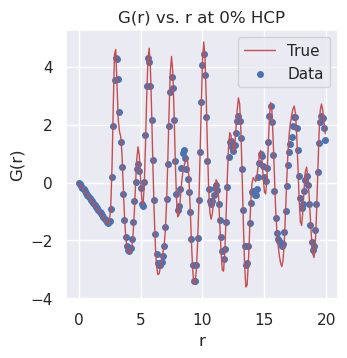

In [23]:
# Select a specific volume fraction and plot G(r) vs r for that volume fraction
vol_frac_true = 0.1337
g_true = get_g(g_bcc, g_hcp, vol_frac_true, bcc_sq1, hcp_sq2)

# Example of plotting G(r) vs r for specific volume fractions against true G(r)

g_0_hcp = G_matrix[0] # 0% HCP
g_100_hcp = G_matrix[-1] # 100% HCP

plot_Gr(r[::10], G_matrix[0][::10], r[::10], g_true[::10], "G(r) vs. r at 0% HCP")

### B) Generate noise for data

In real-world scenarios various sources of error and noise can affect the quality of measured signals. Therefore, to simulate realistic conditions we introduce different types of noise and errors to our 'true' signal. We consider several types of noise common in diffraction experiments, such as Gaussian noise proportional to the signal intensity, systematic errors, linear errors that increase with atomic distances and lastly outliers.

In [24]:
# Function to generate data with noise
#
####################################################################################################

def generate_data_with_noise(r, g_true, g_noise_params = None):
    """
    Generates data with noise based on provided parameters.

    Input:
        r (array): Radius array.
        g_true (array): True G(r) values.
        g_noise_params (dict): Dictionary containing parameters for noise generation, including noise standard deviation, systematic error, linear error, outlier fraction, outlier noise factor, and number of datapoints.

    Output:
        tuple: Returns a tuple containing noisy radius data (r_data), noisy G(r) data (g_data), and indices of the selected data points.
    """

    # Set default noise parameters to no noise
    if g_noise_params is None:
        g_noise_params = {
            'noise_std': 0.0,
            'systematic_error': 0.0,
            'linear_error': 0.0,
            'outlier_fraction': 0.00,
            'outlier_noise_factor': 0.0,
            'n_datapoints': (len(r) // 10)
        }
        
    np.random.seed(42)
    
    # Scale noise with intensity
    noise_std = np.abs(g_noise_params['noise_std'] * g_true)

    # Generate Gaussian noise
    g_noise = np.random.normal(0, noise_std)

    # Optionally add systematic errors or bias
    g_noise += g_noise_params['systematic_error']
    
    # Scale noise with r to account for measurements being more uncertain at larger r
    g_noise *= g_noise_params['linear_error'] * r

    # Introduce some outliers
    for _ in range(int(g_noise_params['outlier_fraction'] * len(g_noise))):  # 5% of points as outliers
        index = np.random.randint(len(g_noise))
        outlier_noise = np.random.normal(0, g_noise_params['outlier_noise_factor'] * noise_std[index])  # Larger noise for outlier
        g_noise[index] += outlier_noise

    # Add noise to the true signal and return
    g_data = g_true + g_noise
    
    # Randompy pick a fixed number of datapoints
    n_datapoints = g_noise_params['n_datapoints']
    indices = np.random.choice(len(g_data), n_datapoints, replace=False)
    indices = np.sort(indices)
    
    g_data = g_data[indices]
    r_data = r[indices]
    
    return r_data, g_data, indices

Finally, we plot the G(r) against r with the newly added noise.

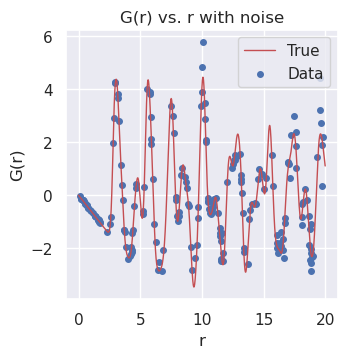

In [25]:
# Set noise parameters
g_noise_params = {
    'noise_std': 0.3,
    'systematic_error': 0.05,
    'linear_error': 0.05,
    'outlier_fraction': 0.05,
    'outlier_noise_factor': 0.1,
    'n_datapoints': (len(r) // 10)
}

# Generate data with noise
r_data, g_data, indices = generate_data_with_noise(r, g_true, g_noise_params = g_noise_params)
G_matrix_data = G_matrix[:, indices]

# Plot the noisy data
plot_Gr(r, g_true, r_data, g_data, "G(r) vs. r with noise")

---
## 7. Non-Bayesian methods; the root mean square minima

This chapter explores the use of Root-Mean-Squared-Error (RMSE) as a non-Bayesian method for estimating the optimal volume fraction in material analysis. The Root-Mean-Squared-Error is the error between target and predicted data calculated as 

\begin{equation}
    RMSE = \frac{1}{N} \sqrt{ \underset{i=1}{\sum^N} (g_{\text{target, i}} - g_{\text{predicted, i}})^2 } 
\end{equation}

where N is the number of datapoints. This is a fast way to estimate the volume fraction and even though it might not be very accurate, an initial estimation can be used as an initial placement for MCMC-walkers or guide the choice of priors.

In [26]:
# Functions to perform RMSE analysis
#
####################################################################################################


def MSE(g_prediction, g_data):
    """
    Calculates the Mean Squared Error (MSE) between the predicted and actual data.

    Input:
        g_prediction (array): Predicted G(r) values.
        g_data (array): Actual G(r) values.

    Output:
        float: The calculated Mean Squared Error.
    """

    n_datapoints = len(g_data)
    residuals = (g_data - g_prediction)**2
    return np.sum(residuals, axis=0) / n_datapoints

def RMSE(mse):
    """
    Calculates the Root Mean Squared Error (RMSE) from the Mean Squared Error (MSE).

    Input:
        mse (float): Mean Squared Error value.

    Output:
        float: The calculated Root Mean Squared Error.
    """

    return np.sqrt(mse)

def get_min_props(RMSE_list):
    """
    Identifies the minimum RMSE and corresponding volume fraction from a list of RMSE values.

    Input:
        RMSE_list (list): List of RMSE values for different volume fractions.

    Output:
        tuple: A tuple containing the index of the minimum RMSE, the minimum RMSE value, and the corresponding volume fraction.
    """

    min_idx = np.argmin(RMSE_list)
    min_RMSE = RMSE_list[min_idx]
    min_vol_frac = vol_fracs[min_idx]
    return min_idx, min_RMSE, min_vol_frac


In [27]:
# Functions to plot RMSE vs. volume fraction
#
####################################################################################################

def plot_rmse_vs_vol_frac(vol_fracs, RMSE_list, title):
    """
    Plots the RMSE values against volume fractions and annotates the minimum RMSE.

    Input:
        vol_fracs (list): List of volume fractions.
        RMSE_list (list): List of RMSE values corresponding to the volume fractions.
        title (str): Title of the plot.

    Output:
        None: This function displays a plot of RMSE vs. volume fraction.
    """

    min_idx, min_RMSE, min_vol_frac = get_min_props(RMSE_list)
    plt.plot(vol_fracs, RMSE_list)
    plt.annotate("Minimum RMSE: {:.4f} at {:.4f}".format(min_RMSE, min_vol_frac), 
                 xy=(min_vol_frac, min_RMSE), xytext=(min_vol_frac + 1*min_vol_frac, min_RMSE), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.xlabel("Volume Fraction HCP")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.show()
    

def plot_g_diff(r, g_true, g_prediction, min_vol_frac, title):
    """
    Plots the true G(r) values, the optimal G(r) prediction, and the difference between the two.

    Input:
        r (array): Radius array.
        g_true (array): True G(r) values.
        g_prediction (array): Predicted G(r) values.
        title (str): Title of the plot.

    Output:
        None: This function displays the plot comparing the true and predicted G(r) values.
    """

    g_diff = g_true - g_prediction
    plt.plot(r, g_true, label="True")
    plt.plot(r, g_prediction, label=f"Optimal prediction at {min_vol_frac:.4f}")
    diff_translation = 1.1*np.min(g_true)
    plt.plot(r, diff_translation + 10*g_diff, label=f"error = {np.mean(g_diff):.4f} $\pm$ {np.std(g_diff):.4f}")
    plt.xlabel("r")
    plt.ylabel("G(r)")
    plt.title(title)
    plt.legend()
    plt.show()

The RMSE values for various volume fractions can be plotted against volume fractions.

Minimum RMSE:  0.350017717628519
Volume fraction at minimum RMSE:  0.13413413413413414


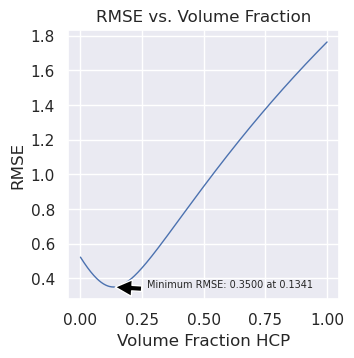

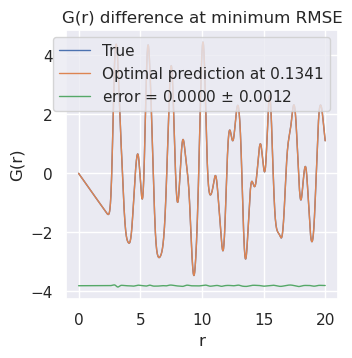

In [28]:
RMSE_list = []
for g_prediction in G_matrix_data:
    RMSE_list.append(np.sqrt((MSE(g_prediction, g_data))))

min_idx, min_RMSE, min_vol_frac = get_min_props(RMSE_list)

print("Minimum RMSE: ", min_RMSE)
print("Volume fraction at minimum RMSE: ", min_vol_frac)

plot_rmse_vs_vol_frac(vol_fracs, RMSE_list, "RMSE vs. Volume Fraction")
plot_g_diff(r, g_true, G_matrix[min_idx], min_vol_frac, "G(r) difference at minimum RMSE")

---
## 8. Bayesian methods to calculate volume fractions

Bayesian analysis offers a probabilistic approach to model uncertainty and incorporates prior knowledge into the analysis. In this section, we develop functions based on the Bayesian framework to calculate the volume fraction of different phases in a material. 

It should also be noted that there are three separate priors in the code below. The first, the log Gaussian prior, is used as a prior for the volume fraction, introducing an assumption that the probability density function for the volume fraction will follow a normal distribution with the standard deviation $\alpha$. This variable is itself subject to Bayesian analysis and regulated by the second prior. Allowing $\alpha$ to vary and be determined through MCMC sampling gives our model the flexibility to adjust its confidence in the volume fraction estimates based on the data. The third prior is associated with the variable $\sigma$ and reflects the uncertainty in our measured data. It is used as the standard deviation of the normal distribution in the likelihood function. By also treating $\sigma$ as a variable and sampling it through MCMC, we allow the model to adjust its confidence in its predictions based on the data it observes such that a larger sigma implies more variability in the data,suggesting a less precise model. It can be shown that the uncertainties of a normal distribution follows an inverse gamma distribution, which is why these partiular functions has been used for $\alpha$ and $\sigma$.

In [29]:
# Functions for Bayesian inference
#
####################################################################################################



def log_gaussian_prior(vol_frac, alpha, vol_frac_params):
    """
    Computes the logarithm of a Gaussian prior for a volume fraction.

    Input:
        vol_frac (float): Volume fraction value to evaluate the prior at.
        alpha (float): Scale parameter for the Gaussian distribution.
        vol_frac_params (dict): Parameters for the volume fraction distribution, including 'max', 'min', and 'prior_center'.

    Output:
        float: Logarithm of the Gaussian prior probability.
    """

    vol_frac_max = vol_frac_params['max']
    vol_frac_min = vol_frac_params['min']
    vol_frac_prior_center = vol_frac_params['prior_center']
    
    if vol_frac < vol_frac_min or vol_frac > vol_frac_max:
        return -np.inf
    else:
        residual = (vol_frac - vol_frac_prior_center)**2
        alpha2 = alpha**2
        
        return -0.5 * np.log(2 * np.pi * alpha2) - 0.5 * residual / alpha2
    
def log_inverse_gamma_prior(var, var_params):
    """
    Computes the logarithm of an inverse gamma prior for a variable.

    Input:
        var (float): Variable to evaluate the prior at.
        var_params (dict): Parameters for the inverse gamma distribution, including 'alpha' and 'beta'.

    Output:
        float: Logarithm of the inverse gamma prior probability.
    """

    alpha = var_params['alpha']
    beta = var_params['beta']
    
    if var < 0:
        return -np.inf
    else:
        return - (alpha + 1) * np.log(var) - beta / var - np.log(special.gamma(alpha)) + alpha * np.log(beta)

def log_likelihood(vol_frac, g_data, g_pred_indices, sigma, bcc_sq1, hcp_sq2):
    """
    Computes the log likelihood of the data given the model parameters.

    Input:
        vol_frac (float): Volume fraction.
        g_data (array): Actual G(r) data.
        g_pred_indices (array): Indices for the predictions.
        sigma (float): Standard deviation of the residuals.
        bcc_sq1, hcp_sq2 (floats): Squared accumulated scattering sums for BCC and HCP phases.

    Output:
        float: Log likelihood of the data.
    """


    g_prediction = get_g(g_bcc, g_hcp, vol_frac, bcc_sq1, hcp_sq2)[g_pred_indices]
    residuals2 = (g_data - g_prediction)**2
    sigma2 = sigma**2
    n_datapoints = len(g_data)
    return - 0.5 * np.sum(residuals2, axis=0) / sigma2 - 0.5 * n_datapoints * np.log(2 * np.pi * sigma2) 


def log_likelihood_jit(vol_frac, g_data, g_pred_indices, sigma, bcc_sq1, hcp_sq2):
    """
    JIT-optimized version of log likelihood computation.

    Input and Output are the same as in log_likelihood.
    """
    
    g_prediction = get_g_jit(g_bcc, g_hcp, vol_frac, bcc_sq1, hcp_sq2)[g_pred_indices]
    residuals2 = (g_data - g_prediction)**2
    sigma2 = sigma**2
    n_datapoints = len(g_data)
    return - 0.5 * np.sum(residuals2, axis=0) / sigma2 - 0.5 * n_datapoints * np.log(2 * np.pi * sigma2) 


def log_posterior(walker_values, params, log_likelihood_func = log_likelihood):
    """
    Computes the log posterior probability for a set of parameters.

    Input:
        walker_values (array): Array of parameters including volume fraction, alpha, and sigma.
        params (dict): Dictionary of additional parameters and data needed for the calculation.

    Output:
        float: Log posterior probability.

    Note: log_posterior_jit follows the same structure but is optimized with JIT.
    """

    
    vol_frac = walker_values[0]
    alpha = walker_values[1]
    sigma = walker_values[2]
    
    vol_frac_params = params['vol_frac_params']
    g_data = params['g_data']
    g_pred_indices = params['g_pred_indices']
    sigma_params = params['sigma_params']
    alpha_params = params['alpha_params']
    
    bcc_sq1 = params['bcc_sq1']
    hcp_sq2 = params['hcp_sq2']
    
    log_prior_vol_frac = log_gaussian_prior(vol_frac, alpha, vol_frac_params)
    log_prior_sigma = log_inverse_gamma_prior(sigma, sigma_params)
    log_prior_alpha = log_inverse_gamma_prior(alpha, alpha_params)
    
    log_likelihood_ = log_likelihood_func(vol_frac, g_data, g_pred_indices, sigma, bcc_sq1, hcp_sq2)
    
    return log_likelihood_ + log_prior_vol_frac + log_prior_sigma + log_prior_alpha


def log_posterior_jit(walker_values, params):
    """
    JIT-optimized version of log posterior computation.
    
    Input and Output are the same as in log_posterior.
    """
    
    return log_posterior(walker_values, params, log_likelihood_func = log_likelihood_jit)

In [30]:
# Function to plot prior distributions
#
####################################################################################################


def plot_prior(vol_fracs, vol_frac_params, alphas, alpha_params, sigmas, sigma_params):
    """
    Plots the log priors for volume fractions, alphas, and sigmas.

    Input:
        vol_fracs (array): Array of volume fractions to plot.
        vol_frac_params, alpha_params, sigma_params (dicts): Parameters for the Gaussian and inverse gamma distributions for volume fraction, alpha, and sigma.

    Output:
        None: This function displays the plots of the log priors.
    """

    vol_frac_prior = []
    alpha_prior = []
    sigma_prior = []
    
    for vol_frac in vol_fracs:
        alpha = 0.01
        vol_frac_prior.append(log_gaussian_prior(vol_frac, alpha, vol_frac_params))
        
    for alpha in alphas:
        alpha_prior.append(log_inverse_gamma_prior(alpha, alpha_params))
    
    for sigma in sigmas:
        sigma_prior.append(log_inverse_gamma_prior(sigma, sigma_params))
    
    fig, axs = plt.subplots(1, 2, figsize=(7.5, 3))
    axs[0].plot(vol_fracs, vol_frac_prior, label="Volume Fraction Prior", linewidth=3)
    axs[1].plot(alphas, alpha_prior, label="Alpha Prior")
    axs[1].plot(sigmas, sigma_prior, label="Sigma Prior")
    for ax in axs:
        ax.set_ylabel("Log Prior")
        ax.legend()
    axs[0].set_xlabel("Volume Fraction")
    axs[1].set_xlabel("Alpha/Sigma")
    fig.suptitle("Log Prior vs. Volume Fraction")
    plt.show()

### B) Choose shape parameters

Choosing the actual shape parameters for the priors, we guess the volume fraction of HCP and say that it's allowed to vary between 0 and 1. If the prior center is set slightly above the OLS estimated value, the model might initially be biased towards this incorrect center. The impact of this bias depends on the strength of the data evidence; strong data can overcome an off-center prior, but weak or noisy data might not.

The shape parameters for the inverse gamma distributions of alpha and sigma have been chosen to punish very small uncertainties, but that very large uncertainties are somewhat less likely than a smaller one. Overly restrictive shape parameters might cause the model to be too rigid and ignore valuable data evidence. Conversely, overly generous shape parameters might make the model too sensitive to data, including noise, leading to overfitting. Often, these parameters are iteratively refined.

Later, we will introduce the concept of autocorrelation as a diagnostic for determining whether the MCMC sampling was successful or not. Autocorrelation time measures the number of steps a walker has to take before it can be considered an independent sample with respect to it's previous position. Overly rigid shape parameters might then be seen as a higher autocorrelation time when the sampling chain struggles to move in the constrained space, while overly generous shape parameters might manifest as very low autocorrelation time where the model captures noise in the data rather than the underlying trend.

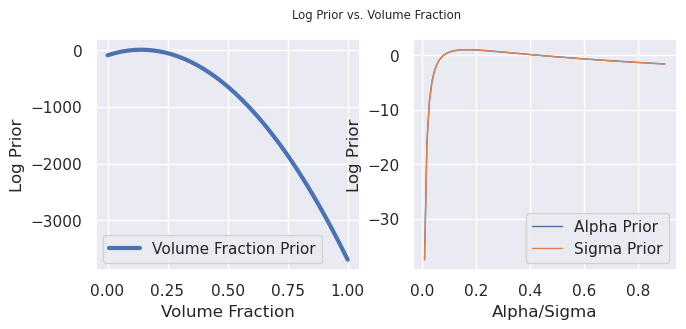

In [31]:
# Set up parameters for the prior distributions
n_hyperparams_for_plot = int(1e2)

alpha_bounds = (0.01, 0.9)
sigma_bounds = (0.01, 0.9)

alpha_range = np.linspace(alpha_bounds[0], alpha_bounds[1], n_hyperparams_for_plot)
sigma_range = np.linspace(sigma_bounds[0], sigma_bounds[1], n_hyperparams_for_plot)
volfrac_range = np.linspace(0, 1, n_hyperparams_for_plot)

alpha_params = {'alpha': 2, 'beta': 0.5}
sigma_params = {'alpha': 2, 'beta': 0.5}
vol_frac_params = {'max': 1, 'min': 0, 'prior_center': 0.25}

vol_frac_params = {'max': 1, 'min': 0, 'prior_center': 0.14}

plot_prior(volfrac_range, vol_frac_params, alpha_range, alpha_params, sigma_range, sigma_params)

### C) Setup MCMC sampling

Next we set up our MCMC sampling. The choice of walkers can be made relatively arbitrary, though it's adviced to not have fewer walkers than half the number of parameters. Here we are generous with our choice of 100 walkers. The choice of the number of steps each walker should take is constricted to the number of steps the autocorrelation function needs to consider the autocorrelation time accurate, and by the number of independent samples that is desired. 

In this notebook with the above priors the largest autocorrelation time $\tau$ is approximately 50. As a rule of thumb samples seperated by $2\tau$ steps are considered independent. This means that we need $100$ steps to collect one independent sample. With 1 walker it then takes $10.000$ steps to collect $1000$ independent samples, but with $100$ walkers we only need $1000$ steps.

It is preferred to give the MCMC sampling some time to sample the configuration space and stabilize before one starts to collect the final samples. Samples made before this burn-in cutoff are then discarded. Sometimes one can visually inspect the sampling chain to approximate the burn-in period. Also plotting the autocorrelation function can be useful as a too short burn-in can be seen as an autocorrelation function that doesn't converge in the early part of the interval. In conclusion the number of walkers and steps used in the code below can be seen to be quite generous and should be lowered for a faster simulation. But as they are the same settings used previously before the program was sped up, I have kept them to give an idea of how much faster the notebook is now.

Lastly, the user can also specify initial positions for the walkers. In the code below these are also quite generous and we start by sampling a relatively large parameter space. Sometimes the inital positions is simply a normal distribution over a previous solution. This could for example be useful when exmaining a time series of a volume fraction changing, as the volume fraction in the next timestep shouldn't be far from the prevviously found volume fraction. For example, here we could have used the volume fraction previously identified as the RMSE-minima.

In [32]:
ndim_vol_frac = 1
ndim_errors = 2

nwalkers, ndim = 100, ndim_vol_frac + ndim_errors

# Initialize uniform random walkers

np.random.seed(42)
pos_vol_frac = [np.random.uniform(0, 1, ndim_vol_frac) for i in range(nwalkers)]
pos_errors = [np.random.uniform(0, 1, ndim_errors) for i in range(nwalkers)]

initial_pos = np.concatenate((pos_vol_frac, pos_errors), axis=1)

#nsteps = int(2.25e3)
nsteps = int(3e3)
nburn = int(2.5e2)


In [33]:
# Function to benchmark the MCMC sampling process
#
####################################################################################################
 

def benchmark_mcmc(benchmark_iterations=5, nsteps_bench = int(1e3), nburn_bench = int(2.5e2)):
    """
    Benchmarks the MCMC sampling process using emcee, comparing standard and JIT-optimized versions.

    Input:
        None: Uses global variables and parameters defined outside the function.

    Output:
        None: This function prints out timing results and conclusions of the benchmark.
    """
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[{'vol_frac_params': vol_frac_params,
                                                                            'sigma_params': sigma_params,
                                                                            'alpha_params': alpha_params,
                                                                            'g_data': g_data,
                                                                            'g_pred_indices': indices,
                                                                            'bcc_sq1': bcc_sq1,
                                                                            'hcp_sq2': hcp_sq2,
                                                                            }])

    sampler_jit = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jit, args=[{'vol_frac_params': vol_frac_params,
                                                                            'sigma_params': sigma_params,
                                                                            'alpha_params': alpha_params,
                                                                            'g_data': g_data,
                                                                            'g_pred_indices': indices,
                                                                            'bcc_sq1': bcc_sq1,
                                                                            'hcp_sq2': hcp_sq2,
                                                                            }])
    
    timers = []
    for sampler in [sampler, sampler_jit]:
        
        time_per_iteration = timeit(lambda: sampler.run_mcmc(initial_pos, nsteps_bench + nburn_bench, progress=True), number=benchmark_iterations) / benchmark_iterations
        timers.append(time_per_iteration)
        print(f"{sampler.__class__.__name__}: {time_per_iteration:2e} seconds")
    
    print(f"Conclusion: JIT version is {timers[0]/timers[1]:.1f} times faster than the non-JIT version")

To assess the efficiency of our MCMC sampling process, we benchmark both standard and JIT-optimized versions. This comparison shows some performance gained from using the jit-version for calculating the PDF, but this increase is very small. This is theoretically expected, in part because each PDF calculation is separated by many other steps but also because it is not the calculation driving the computational costs.

However, in an old implementation where the accumulated scattering sum was recalculated for each guess of the volume fraction one MCMC sampling took 4 minutes, as opposed to the current 3 seconds.

In [34]:
benchmark_mcmc()

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:03<00:00, 405.63it/s]


EnsembleSampler: 3.185158e+00 seconds


100%|██████████| 1250/1250 [00:06<00:00, 192.84it/s]

EnsembleSampler: 5.029847e+00 seconds
Conclusion: JIT version is 0.6 times faster than the non-JIT version


In [35]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jit, args=[{'vol_frac_params': vol_frac_params,
                                                                        'sigma_params': sigma_params,
                                                                        'alpha_params': alpha_params,
                                                                        'g_data': g_data,
                                                                        'g_pred_indices': indices,
                                                                        'bcc_sq1': bcc_sq1,
                                                                        'hcp_sq2': hcp_sq2,
                                                                        }])

sampler.run_mcmc(initial_pos, nsteps+nburn, progress=True)

  0%|          | 0/3250 [00:00<?, ?it/s]

100%|██████████| 3250/3250 [00:17<00:00, 182.16it/s]


State([[0.14573475 0.33709695 0.32265087]
 [0.12740146 0.45361715 0.35588542]
 [0.12744542 0.3475876  0.32432536]
 [0.14334714 0.97627121 0.37576476]
 [0.13426275 0.0928888  0.35178757]
 [0.13207386 0.13704061 0.35579203]
 [0.14241211 0.38526897 0.37148742]
 [0.13591458 0.06385459 0.37223604]
 [0.13744159 0.11358353 0.35656285]
 [0.12978346 0.12584355 0.37526754]
 [0.14458588 0.07558114 0.3314505 ]
 [0.12466472 0.20168276 0.3293403 ]
 [0.1415575  0.40093894 0.3385279 ]
 [0.12827549 0.17388834 0.35706073]
 [0.12327318 0.31296991 0.34492076]
 [0.12587318 0.19831222 0.40699419]
 [0.1243337  0.07671627 0.35371239]
 [0.13199476 0.08578519 0.35342913]
 [0.12759792 0.36204734 0.34579331]
 [0.13889008 0.19321824 0.38413193]
 [0.12850346 0.59103456 0.37790018]
 [0.12667894 0.67381012 0.35933962]
 [0.13714206 0.13187954 0.3630988 ]
 [0.12842678 0.10587285 0.3273762 ]
 [0.13010265 0.34430662 0.36533963]
 [0.12339503 0.12805733 0.35999828]
 [0.12631162 0.87829153 0.37621231]
 [0.13778356 0.2419218

The chains of guesses for the volume fractions and uncertainty parameters are iteratively adjusted during MCMC sampling. The samplings autocorrelation time provides a measure of the interval of iterations that must separate two samples for them to be considered uncorrelated. We therefore adhere to best practice and thin the sample chain so that we keep samples separated by $2 \max (\tau)$.

In [36]:
try:
    tau = sampler.get_autocorr_time()
    thinning_param = int(2 * np.max(tau))
    print(f"Autocorrelation time: {tau}, thinning interval: {thinning_param}")
except emcee.autocorr.AutocorrError as e:
    print("Autocorrelation time estimation failed:", e)
    thinning_param = 1  # Fallback if autocorrelation time can't be estimated

samples = sampler.get_chain()
print(samples.shape)

samples_thin = sampler.get_chain(thin=thinning_param, discard=nburn)
print(samples_thin.shape)

Autocorrelation time: [26.70305652 43.10078404 32.90013939], thinning interval: 86
(3250, 100, 3)
(34, 100, 3)


### D) Plot and analyze the performed sampling

After completing the MCMC sampling, we turn to analyzing the results. This involves visualizing parameter distributions, assessing autocorrelation, and interpreting the implications of our findings.

In [37]:
# Function to plot MCMC parameter distributions
#
####################################################################################################


def plot_mcmc_parameter(samples, parameter_name, parameter_index, nburn):
    """
    Plots density estimation, trace, and autocorrelation for a specific MCMC parameter.

    Input:
        samples (array): Array of MCMC samples.
        parameter_name (str): Name of the parameter to plot.
        parameter_index (int): Index of the parameter in the samples.
        nburn (int): Number of samples to discard as burn-in.

    Output:
        None: This function displays plots for the specified parameter.
    """
    
    # Create a figure with a grid of subplots for density and trace plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # One row for one parameter, and three columns for density, trace, and autocorrelation

    # Extract the samples for the specific parameter
    parameter_samples = samples[:, :, parameter_index]

    # Plot the density estimation of the samples
    sns.kdeplot(parameter_samples[nburn:].flatten(), ax=axes[0], fill=True)
    axes[0].set_title(f'Logarithmic posterior PDF\n{parameter_name}')
    axes[0].set_ylabel('Log. Posterior prob. amplitude')
    axes[0].set_xlabel('Parameter Value')

    # Calculate mean and quantiles for the density plot
    mean_val = np.mean(parameter_samples[nburn:])
    quantiles_val = np.percentile(parameter_samples[nburn:], [16, 84])

    # Add a vertical line for the mean
    axes[0].axvline(mean_val, color='k', linestyle='--', label=f'Mean: {mean_val:.4f}')

    # Add vertical lines for the quantiles
    axes[0].axvline(quantiles_val[0], color='k', linestyle=':', label=f'Mean - $\sigma$: {quantiles_val[0]:.4f}')
    axes[0].axvline(quantiles_val[1], color='k', linestyle=':', label=f'Mean + $\sigma$: {quantiles_val[1]:.4f}')

    # Add the legend to the density plot
    axes[0].legend()

    # Plot the trace (walkers over steps)
    axes[1].plot(parameter_samples, color='k', alpha=0.3)
    axes[1].set_title(f'Trace\n{parameter_name}')
    axes[1].set_ylabel('Parameter Value')
    axes[1].set_xlabel('Step')

    # Add a dashed line for the burn-in cut-off
    axes[1].axvline(nburn, color='red', linestyle='--', label='Burn-in cut-off')
    axes[1].legend()

    # Compute and plot the autocorrelation for the parameter
    autocorr = emcee.autocorr.function_1d(parameter_samples[nburn:].flatten())
    axes[2].stem(autocorr, linefmt='C0-', markerfmt='C0o', basefmt="C0-")
    axes[2].set_title(f'Autocorrelation\n{parameter_name}')
    axes[2].set_xlabel('Lag')
    axes[2].set_ylabel('Autocorrelation')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

We plot the probability density estimation, trace, and autocorrelation for each parameter of interest. We expect the volume fraction to be relatively normally distributed and the uncertainty parameters to roughly follow gamma distributions, the traces should ideally look like hairy-caterpillars and the autocorrelation function should show a rapid initial drop before stabilizing. The decay of this function is actually what is used to calculate the autocorrelation time.

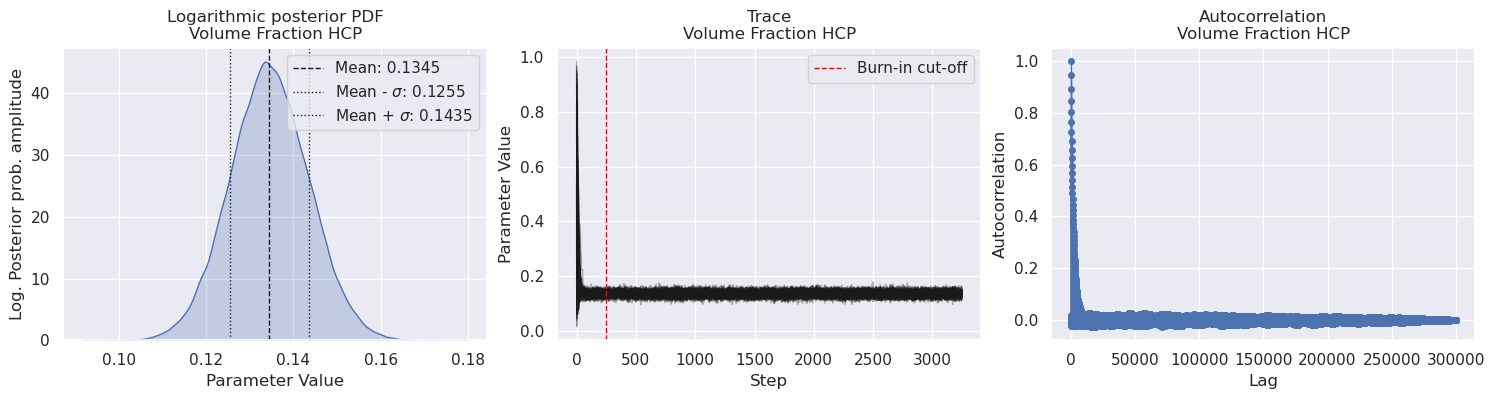

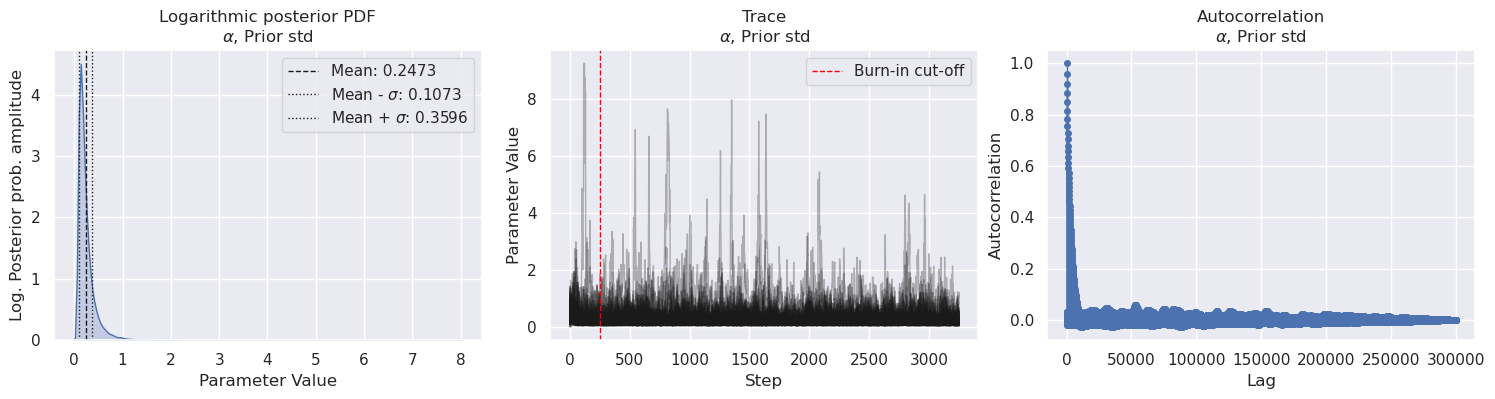

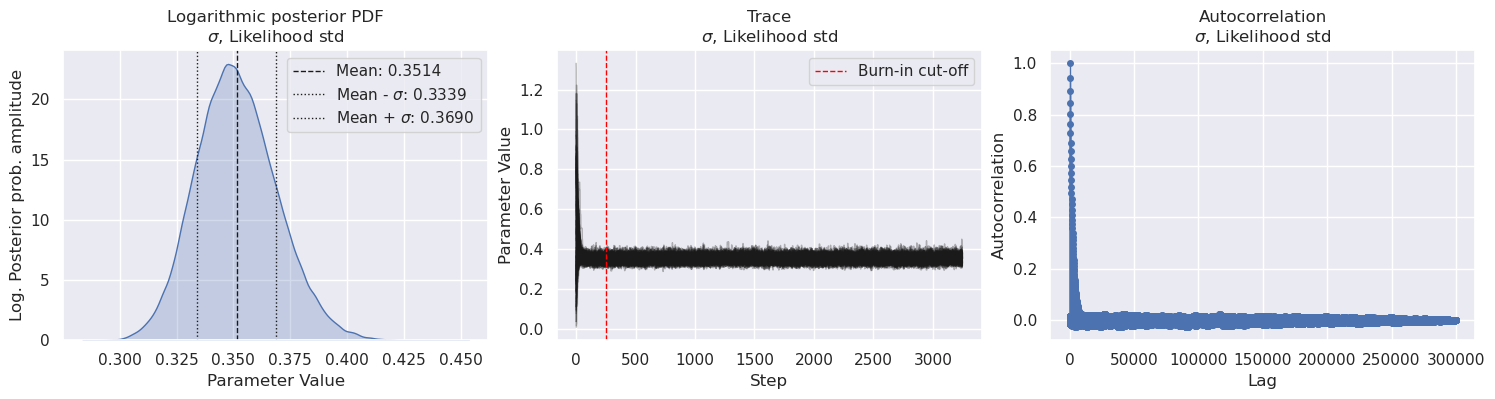

In [38]:
plot_mcmc_parameter(samples, rf'Volume Fraction HCP', 0, nburn)
plot_mcmc_parameter(samples, rf'$\alpha$, Prior std', 1, nburn)
plot_mcmc_parameter(samples, rf'$\sigma$, Likelihood std', 2, nburn)

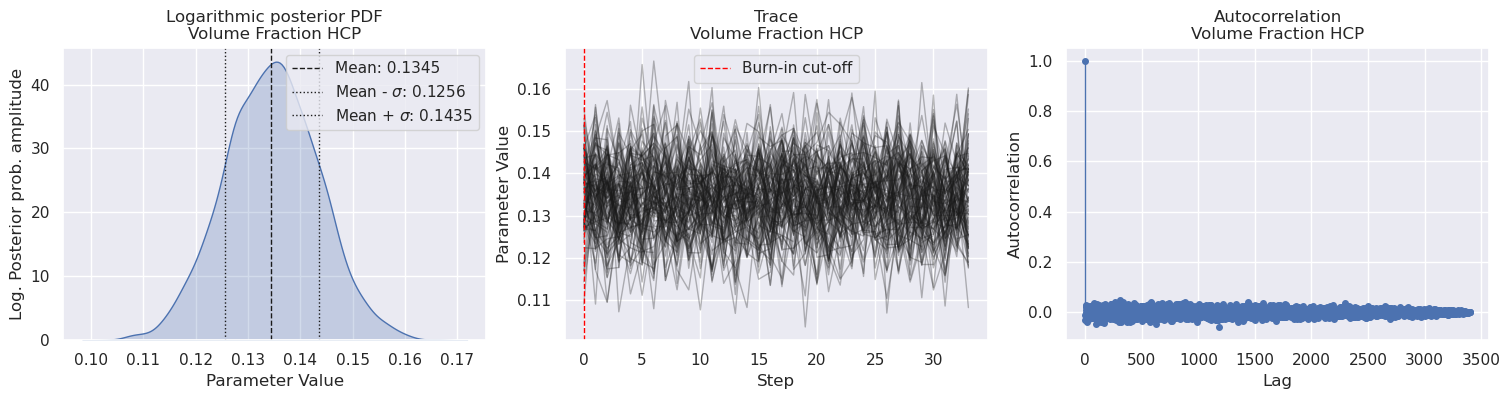

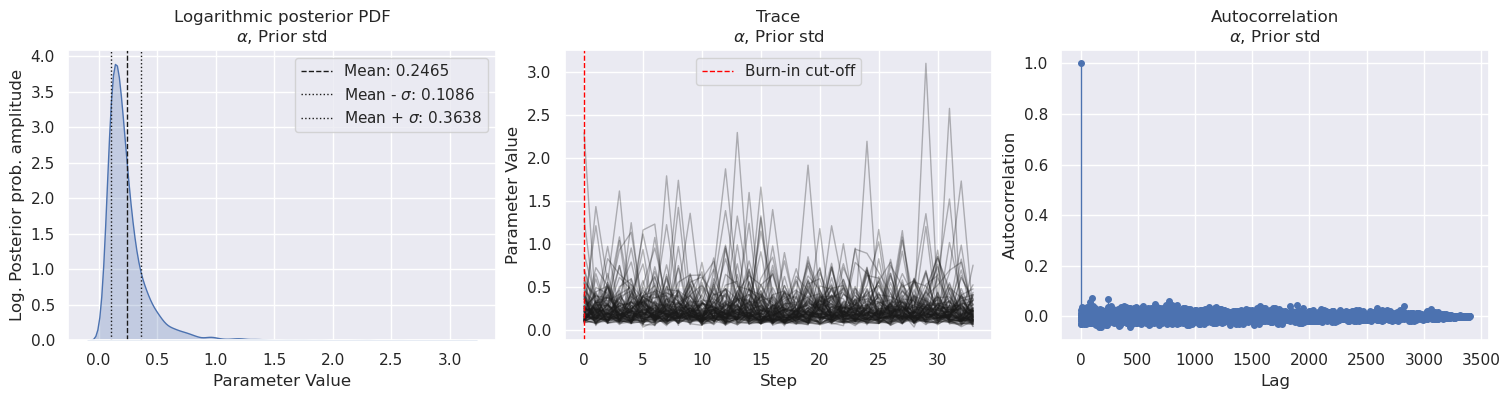

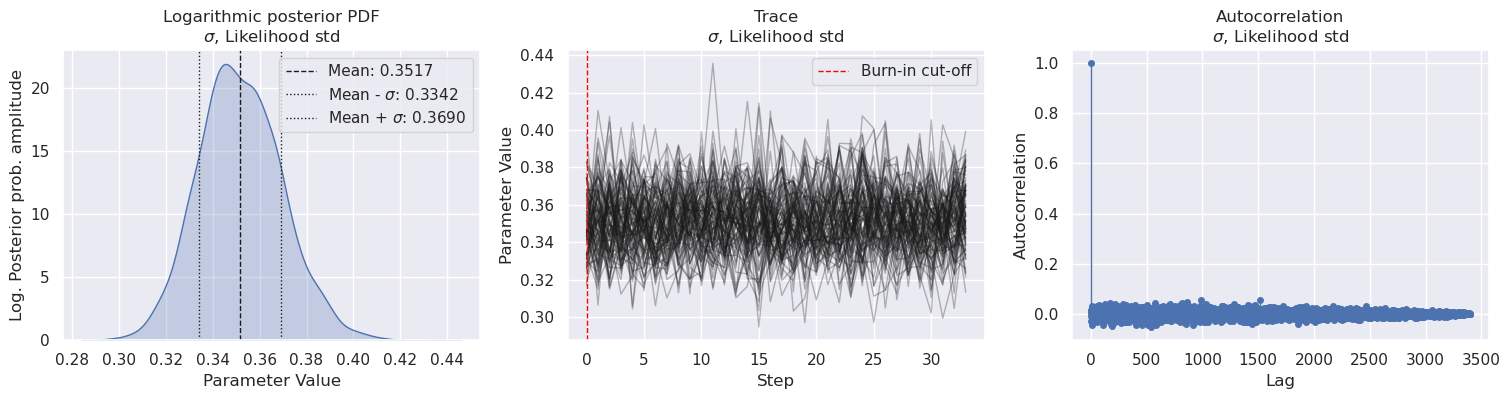

In [39]:
plot_mcmc_parameter(samples_thin, rf'Volume Fraction HCP', 0, 0)
plot_mcmc_parameter(samples_thin, rf'$\alpha$, Prior std', 1, 0)
plot_mcmc_parameter(samples_thin, rf'$\sigma$, Likelihood std', 2, 0)

We then focus on the predictions of volume fractions and compare them with the true values.

In [40]:
# Function to plot the uncorrelated predictions of volume fractions from MCMC samples
####################################################################################################


def plot_vol_frac_predictions(vol_frac_true, vol_frac_predictions):
    """
    Plots predictions of volume fraction along with the true value.

    Input:
        vol_frac_true (float): True volume fraction value.
        vol_frac_predictions (list): List of predicted volume fraction values.

    Output:
        None: This function displays a scatter plot of the predictions with errors.
    """

    # Make a scatter plot with errors for predictions over the number of walkes and vertical lines for the true value
    fig, ax = plt.subplots()
    ax.errorbar(np.arange(len(vol_frac_predictions)), vol_frac_predictions, yerr=np.std(samples_thin[:, :, 0], axis=0), fmt='o', label="Predictions")
    ax.axhline(vol_frac_true, color="r", label="True")
    ax.set_xlabel("Walker")
    ax.set_ylabel("Volume Fraction HCP")
    ax.set_title("Volume Fraction HCP Predictions")
    ax.legend()
    plt.show()

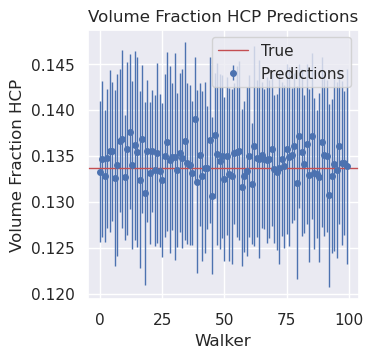

Volume fraction HCP: 0.1347 + 0.0014 - 0.0018$


In [41]:

vol_frac_predictions = np.sum(samples_thin[:, :, 0], axis=0) / len(samples_thin)
plot_vol_frac_predictions(vol_frac_true, vol_frac_predictions)


volume_fraction_quantiles = np.percentile(vol_frac_predictions, [16, 50, 84])

mean_volume_fraction = volume_fraction_quantiles[1]
lower_sigma = volume_fraction_quantiles[1] - volume_fraction_quantiles[0]
upper_sigma = volume_fraction_quantiles[2] - volume_fraction_quantiles[1]

print(f"Volume fraction HCP: {mean_volume_fraction:.4f} + {upper_sigma:.4f} - {lower_sigma:.4f}$")

And finally, by plotting the predicted G(r) functions and their differences from the true values we can quantify the accuracy and precision of our Bayesian model.

In [42]:
# Function to plot the predicted G matrix for a specific volume fraction
#
####################################################################################################

def plot_g_mcmc(r, g_true, r_data, g_data, samples_thin, title):
    """
    Plots the true and predicted G(r) functions along with their differences.

    Input:
        r (array): Radius array.
        g_true (array): True G(r) values.
        r_data (array): Radius values of the data.
        g_data (array): G(r) values of the data.
        samples_thin (array): Thinned MCMC samples for volume fraction predictions.
        title (str): Title of the plot.

    Output:
        None: This function displays the plot.
    """

    
    plt.scatter(r_data, g_data, label="Data", color="b", alpha = 0.6)
    plt.plot(r, g_true, label="True", color="r")
    
    sample_mean = np.mean(samples_thin[:, :, 0])
    g_prediction_mean = get_g(g_bcc, g_hcp, sample_mean, bcc_sq1, hcp_sq2)
    
    plt.plot(r, g_prediction_mean, label=f"Mean prediction at {sample_mean:.4f}", color="g")
    
    error = g_prediction_mean - g_true
    error_std = np.std(error)
    error_mean = np.mean(error)
    error_translation_for_plot = 1.1*np.min(g_true)
    plt.plot(r, error_translation_for_plot + error, label=f"error={error_mean:.4f} $\pm$ {error_std:.2f}", color="k")
    #plt.vlines(r, 1.1*np.min(g_true) + 1*error_mean, 1.1*np.min(g_true) + 1*error, color="k", alpha=0.2)
    plt.fill_between(r, error_translation_for_plot + error_mean - error_std, error_translation_for_plot + error_mean + error_std, color="k", alpha=0.2)
    
    # If you want to plot all the predictions, uncomment the following lines
    """ samples_thin = np.mean(samples_thin, axis=0)
    for sample in samples_thin:
        g_prediction = get_g(g_bcc, g_hcp, sample[0], pc)
        plt.plot(r, g_prediction, color="k", alpha=0.2)
    # Add legend entry for the predictions
    plt.plot([], [], color="k", alpha=0.2, label="MCMC predictions") """
    
    plt.xlabel("r")
    plt.ylabel("G(r)")
    plt.title(title)
    plt.legend()
    plt.show()
    

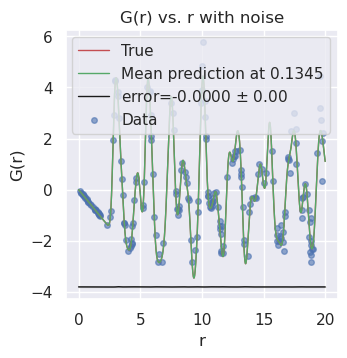

In [43]:
plot_g_mcmc(r, g_true, r_data, g_data, samples_thin, "G(r) vs. r with noise")

---
## 9. Bayesian Analysis for identifying phase transitions

In this chapter, we apply our Bayesian analysis to investigate a phase transition and the potential appearance of an HCP phase. Utilizing techniques developed earlier, we simulate a noisy continous phase transition in volume fraction over time.

In [44]:
# Function to create a true phase transition in volume fraction
#
####################################################################################################


def true_phase_transition_volume_fraction(initial_volume_fraction = 0., final_volume_fraction = 0.2, volume_fraction_fluctuation = 0.01, measurement_resolution = 4, random_seed=42):
    """
    Simulates a smooth phase transition in volume fraction over time.

    Input:
        measurement_resolution (int): Time interval between measurements in seconds. Default is 1.
        random_seed (int): Seed for the random number generator. Default is 42.

    Output:
        array: Simulated volume fraction values over time.
    """

    time_before_phase_transition = 200  # seconds
    time_for_phase_transition_to_complete = 400  # seconds
    time_after_phase_transition = 200  # seconds

    # Create the time series
    total_time = time_before_phase_transition + time_for_phase_transition_to_complete + time_after_phase_transition
    
    #time_series = np.arange(0, total_time, measurement_resolution)
    
    total_number_of_measurements = int(total_time / measurement_resolution)
    
    time_series = np.linspace(0, total_time, total_number_of_measurements)

    volume_fraction = np.zeros_like(time_series)

    # Add a sigmoid function with a smooth transition durin time_for_phase_transition_to_complete seconds
    transition_times = time_series - time_before_phase_transition * 1.5
    volume_fraction = 0.5 * (1 + np.tanh(transition_times / (time_for_phase_transition_to_complete / 5)))
    
    # Scale the volume fraction to the desired range for the transition part
    volume_fraction = initial_volume_fraction + volume_fraction * (final_volume_fraction - initial_volume_fraction)

    # Set a random seed for reproducibility
    np.random.seed(random_seed)
    
    # Add noise to the volume fraction
    volume_fraction += np.random.normal(0, volume_fraction_fluctuation, volume_fraction.shape)

    # Make sure the volume fraction is between 0 and 1
    volume_fraction = np.clip(volume_fraction, 0, 1)
    
    plt.plot(time_series, volume_fraction)
    plt.xlabel('Time (s)')
    plt.ylabel('Volume Fraction')
    plt.title('Simulated Phase Transition Volume Fraction (Smooth Transition)' + f'\n {total_number_of_measurements} measurements')
    plt.show()
    
    return volume_fraction



The phase transition function is designed to simulate a gradual phase transition. It generates a time series of volume fraction values that smoothly transition from an initial to a final state, with added noise to mimic real-world uncertainties. This simulated data serves as a foundation for testing our Bayesian analysis approach in detecting and characterizing phase transitions.

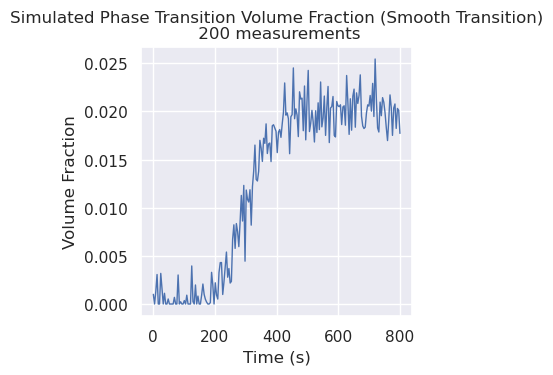

In [45]:
# Call the function to plot the smoother phase transition
initial_volume_fraction = 0.0
final_volume_fraction = 0.02

volume_fraction_fluctuation = 0.002

true_volume_fraction_time_series = true_phase_transition_volume_fraction(initial_volume_fraction = initial_volume_fraction, final_volume_fraction = final_volume_fraction, volume_fraction_fluctuation = volume_fraction_fluctuation)

We can then calculate the G_matrix, that is, the time series of PDFs corresponding to the changing volume fractions.

Larger magnitudes of noise was seen to lead to overestimation of the initial volume fractions, and are therefore slightly dampened.

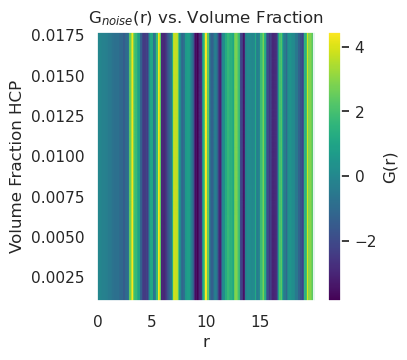

In [53]:
G_matrix_true = get_G_matrix_vectorized(true_volume_fraction_time_series, g_bcc, g_hcp, bcc_sq1, hcp_sq2)

g_noise_params = {
    'noise_std': 0.3,
    'systematic_error': 0.025,
    'linear_error': 0.025,
    'outlier_fraction': 0.025,
    'outlier_noise_factor': 0.05,
    'n_datapoints': (len(r) // 10)
}

# Add noise to each g in G matrix with generate_data_with_noise
G_matrix_noisy_time_series = np.zeros((len(true_volume_fraction_time_series), g_noise_params['n_datapoints']))
for index, g in enumerate(G_matrix_true):
    #r_data, g_data, indices = generate_data_with_noise(r, g, g_noise_params = g_noise_params)
    r_data, g_data, indices = generate_data_with_noise(r, g, g_noise_params = g_noise_params)
    G_matrix_noisy_time_series[index] = g_data

plot_heatmap(r, true_volume_fraction_time_series, G_matrix_noisy_time_series, "r", "Volume Fraction HCP", "G(r)", "G$_{{noise}}$(r) vs. Volume Fraction")

The prior for the volume fraction is shifted to a value between the min and max volume fractions

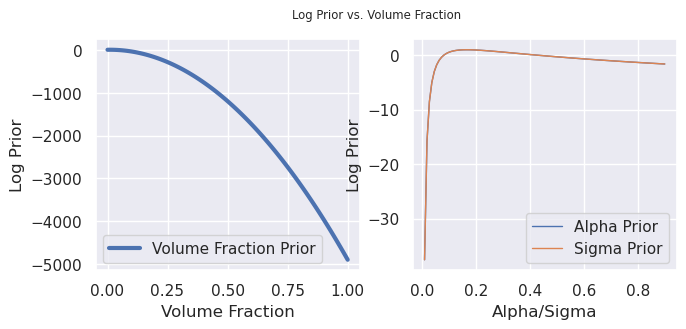

In [54]:
alpha_params = {'alpha': 2, 'beta': 0.5}
sigma_params = {'alpha': 2, 'beta': 0.5}
vol_frac_params = {'max': 1, 'min': 0, 'prior_center': 0.01}

plot_prior(volfrac_range, vol_frac_params, alpha_range, alpha_params, sigma_range, sigma_params)

Initial guesses for the volume fraction is also set between the min and the max volume fractions

In [55]:
initial_vol_frac_guess = 0.01

ndim_vol_frac = 1
ndim_errors = 2

nwalkers, ndim = 100, ndim_vol_frac + ndim_errors

# Initialize uniform random walkers
pos_vol_frac = [np.random.uniform(0, initial_vol_frac_guess, ndim_vol_frac) for i in range(nwalkers)]
pos_errors = [np.random.uniform(0, 1, ndim_errors) for i in range(nwalkers)]

initial_pos = np.concatenate((pos_vol_frac, pos_errors), axis=1)

nsteps = int(2.5e3)
nburn = int(2.5e2)

We employ parallel computing with the python package Joblib to make the MCMC analysis of our time-series data more efficient. This approach allows us to simultaneously process time-steps simultaneously. 

In a previous implementation, this function was actually not parallelizable where the last guess of the volume fraction for one timestep was used to initiate the volume fractions prior in the next timestep. However, this provided a marginal gain in accuracy. Therefore the method was discarder for the computational efficiency that parallelization allows.

In [56]:
# Functions to perform MCMC analysis of the time series
#
####################################################################################################


def mcmc_analysis_for_single_g(g, nwalkers, ndim, log_posterior_jit, vol_frac_params, sigma_params, alpha_params, bcc_sq1, hcp_sq2, nsteps, nburn, initial_pos, ndim_vol_frac):
    """
    Conducts MCMC analysis for a single G matrix, extracting mean and quantile information for each parameter.

    Parameters:
        g (array): Single G matrix for which the MCMC analysis is to be performed.
        nwalkers (int): Number of walkers in the MCMC sampler.
        ndim (int): Number of dimensions in the MCMC parameter space.
        log_posterior_jit (function): JIT-optimized log posterior function.
        vol_frac_params (dict): Parameters related to volume fraction.
        sigma_params (dict): Parameters related to the sigma value.
        alpha_params (dict): Parameters related to the alpha value.
        bcc_sq1, hcp_sq2 (float): Squared accumulated scattering sums for BCC and HCP phases.
        nsteps (int): Number of steps for MCMC analysis.
        nburn (int): Number of burn-in steps for MCMC analysis.
        initial_pos (array): Initial positions of the MCMC walkers.
        ndim_vol_frac (int): Number of dimensions for the volume fraction.

    Returns:
        dict: A dictionary containing mean and quantile values for each parameter in the MCMC analysis.
        
    """
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_jit, args=[{'vol_frac_params': vol_frac_params,
                                                                              'sigma_params': sigma_params,
                                                                              'alpha_params': alpha_params,
                                                                              'g_data': g,
                                                                              'g_pred_indices': indices,
                                                                              'bcc_sq1': bcc_sq1,
                                                                              'hcp_sq2': hcp_sq2,
                                                                              }])

    sampler.run_mcmc(initial_pos, nsteps+nburn, progress=True)
    
    # Handling autocorrelation and thinning
    try:
        tau = sampler.get_autocorr_time()
        thin = int(2 * np.max(tau))
    except emcee.autocorr.AutocorrError:
        thin = 1  # Fallback if autocorrelation time can't be estimated

    samples_thin = sampler.get_chain(thin=thin, discard=nburn)

    # Extract and calculate mean and quantiles for each parameter
    results = {}
    for idx in range(ndim):
        param_samples = samples_thin[:, :, idx]
        results[f'mean_{idx}'] = np.mean(param_samples)
        results[f'quantiles_{idx}'] = np.percentile(param_samples, [16, 84])

    return results



def perform_mcmc_analysis_of_timeseries(G_matrix_noisy_time_series, nwalkers, ndim, log_posterior_jit, vol_frac_params, sigma_params, alpha_params, bcc_sq1, hcp_sq2, nsteps, nburn, initial_pos, ndim_vol_frac, notebook_settings):
    """
    Performs a parallelized Markov Chain Monte Carlo (MCMC) analysis on a series of G matrices.
    The function takes approximately 10 minutes for 1600 timesteps (g PDFs) and 3 minutes for 400 timesteps.
    By default quantiles are set to 16 and 84.
    
    
    Parameters:
        G_matrix_noisy_time_series (array): Array of G matrices for MCMC analysis.
        nwalkers, ndim (int): Number of walkers and dimensions for the MCMC sampler.
        log_posterior_jit (function): JIT-optimized log posterior function.
        vol_frac_params, sigma_params, alpha_params (dict): Parameter dictionaries for volume fraction, sigma, and alpha.
        bcc_sq1, hcp_sq2 (float): Squared accumulated scattering sums for BCC and HCP phases.
        nsteps, nburn (int): Number of steps for MCMC and number of burn-in steps.
        initial_pos (array): Initial position of the MCMC walkers.
        ndim_vol_frac (int): Dimension for volume fraction.
        notebook_settings (dict): Settings dictionary to control function behavior.

    Returns:
        pandas.DataFrame: Results from the MCMC analysis, including mean, lower, and upper quantiles for volume fraction, alpha, and sigma.
    """
    
    # Parallel computation
    num_cores = notebook_settings.get("num_cores", -1)
    
    mcmc_results = Parallel(n_jobs=num_cores)(delayed(mcmc_analysis_for_single_g)(
        g, nwalkers, ndim, log_posterior_jit, vol_frac_params, sigma_params, alpha_params, bcc_sq1, hcp_sq2, nsteps, nburn, initial_pos, ndim_vol_frac
    ) for g in G_matrix_noisy_time_series)
    
    # If this wouldn't be parallelized, it would look like this and all steps would be made sequentially
    # This method is approximately 8 times slower than the parallelized version
    
    """ 
    mcmc_results = []
    for g in G_matrix_noisy_time_series:
        mcmc_results.append(mcmc_analysis_for_single_g(g, nwalkers, ndim, log_posterior_jit, vol_frac_params, sigma_params, alpha_params, bcc_sq1, hcp_sq2, nsteps, nburn, initial_pos, ndim_vol_frac))
    
    """

    # Processing results
    mean_vol_fracs, quantiles_vol_fracs = [], []
    mean_alphas, quantiles_alphas = [], []
    mean_sigmas, quantiles_sigmas = [], []

    for result in mcmc_results:
        mean_vol_fracs.append(result['mean_0'])
        quantiles_vol_fracs.append(result['quantiles_0'])

        mean_alphas.append(result['mean_1'])
        quantiles_alphas.append(result['quantiles_1'])

        mean_sigmas.append(result['mean_2'])
        quantiles_sigmas.append(result['quantiles_2'])

    # Create and format DataFrame
    simulated_results = pd.DataFrame({
        'Volume Fraction HCP': mean_vol_fracs,
        'Volume Fraction HCP Lower': [q[0] for q in quantiles_vol_fracs],
        'Volume Fraction HCP Upper': [q[1] for q in quantiles_vol_fracs],
        'Alpha': mean_alphas,
        'Alpha Lower': [q[0] for q in quantiles_alphas],
        'Alpha Upper': [q[1] for q in quantiles_alphas],
        'Sigma': mean_sigmas,
        'Sigma Lower': [q[0] for q in quantiles_sigmas],
        'Sigma Upper': [q[1] for q in quantiles_sigmas]
    })

    if notebook_settings.get("save_volume_fraction_analysis"):
        simulated_results.to_csv('simulated_results.csv')

    return simulated_results

In [57]:
simulated_results = perform_mcmc_analysis_of_timeseries(G_matrix_noisy_time_series, nwalkers, ndim, log_posterior_jit, vol_frac_params, sigma_params, alpha_params, bcc_sq1, hcp_sq2, nsteps, nburn, initial_pos, ndim_vol_frac, notebook_settings)

  1%|          | 30/2750 [00:00<00:10, 260.50it/s]

100%|██████████| 2750/2750 [00:10<00:00, 251.90it/s]

100%|██████████| 2750/2750 [00:06<00:00, 401.04it/s]


In [58]:
# Function to plot the predicted volume fraction over time
#
####################################################################################################

def plot_volume_fraction_sweep(true_volume_fraction_time_series, simulated_results, title, thinning_param = 5):
    """
    Plots the true and predicted volume fraction HCP over time.

    Input:
        true_volume_fraction_time_series (array): True time series of volume fraction.
        simulated_results (DataFrame): Simulated results containing predictions and confidence intervals.
        title (str): Title of the plot.

    Output:
        None: This function displays a plot of volume fraction over time.
    """

    # Plot the results
    fig, ax = plt.subplots()

    # Thin the data to avoid clutter
    true_volume_fraction_time_series_thin = true_volume_fraction_time_series[::thinning_param]
    mean_vol_fracs_thin = simulated_results['Volume Fraction HCP'][::thinning_param].to_numpy()
    quantiles_vol_fracs_thin = simulated_results[['Volume Fraction HCP Lower', 'Volume Fraction HCP Upper']][::thinning_param].to_numpy()
    
    # Plot the mean volume fractions
    ax.plot(true_volume_fraction_time_series_thin, label="True", color="r", linewidth=2)
    ax.plot(mean_vol_fracs_thin, label="Predicted", color="b")
    ax.fill_between(np.arange(len(mean_vol_fracs_thin)), [q[0] for q in quantiles_vol_fracs_thin], [q[1] for q in quantiles_vol_fracs_thin], color="b", alpha=0.4, label="68% Confidence Interval")
    ax.set_xlabel("Time")
    ax.set_ylabel("Volume Fraction HCP")
    ax.set_title(f"Volume Fraction HCP Predictions, thinned by {thinning_param}")
    ax.legend()
    plt.show()


The plotting function visualizes the actual and predicted volume fractions of HCP over time. The inclusion of confidence intervals in the plot provides a measure of the model's certainty over the course of the transition.

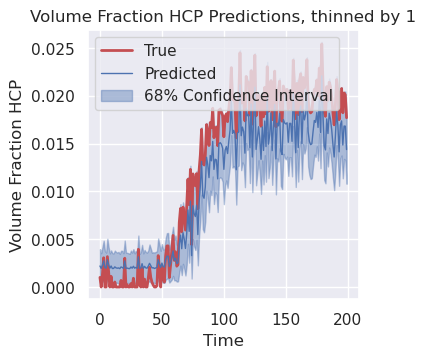

In [59]:

thinning_param = 1
plot_volume_fraction_sweep(true_volume_fraction_time_series, simulated_results, "Volume Fraction HCP Predictions", thinning_param = thinning_param)


---
## 10. Future Improvements

In the current notebook a systematic benchmarking of the Bayesian method against RMSE estimation is absent. While both methods have demonstrated relative accuracy, it would be illuminating to explore their performance under various noise conditions, such as heavy or minimal noise. Should the RMSE method prove sufficiently accurate under certain conditions, it could serve as a preliminary tool to identify ranges possible phase transitions. These ranges could then be subjected to a potentially more accurate Bayesian analysis.

Adapting the initial guess of the volume fraction as a time-dependent parameter is another possibility for improving early phase analysis. For example, a progressive increase in the initial guess aligned with the phase transition, would likely reduce the overestimation of initial volume fraction and underestimation of the final. This could involve a detailed analysis of the volume fractions at the start and end of the time series, followed by fitting a simple linear function to these points to use as initial guesses for time steps inbetween. 

The shape parameters for priors could also be optimized. By conducting simulations with varied parameters and analyzing the resulting errors, one could identify a cross-validated error minimum, which would indicating optimal parameter choices.

Incorporating detailed noise characteristics into the Bayesian framework is another area of improvement. If certain patterns in error distribution are known, such as increased errors in more intense parts of the PDF, adjusting the priors or the likelihood function to reflect this variable noise level could significantly enhance model accuracy. This might involve modeling the sigma parameter as a function of the PDF intensity or implementing more complex noise models within the likelihood function.

Lastly, extending the Bayesian methodology to include a third phase in the analysis is a compelling continuation of this work. Simultaneously identifying and tracking the time evolution of volume fractions for three distinct phases would be an important step in moving toward practical real-life applications. 